#### Adicionando o caminho do projeto ao path

#### Instalando sklearn

In [84]:
%pip install scikit-learn
%pip install contextily
%pip install geopandas

#### Importando as bibliotecas necessárias para a análise

In [85]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency

#### Lendo os dados da base tratada de 2018 a 2024

In [86]:
df_accidents = pd.read_csv(
    "/content/datatran2018_2024_v1.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428567 entries, 0 to 428566
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        428567 non-null  float64       
 1   data_inversa              428567 non-null  datetime64[ns]
 2   tipo_data                 428567 non-null  object        
 3   mes_ano                   428567 non-null  datetime64[ns]
 4   dia_semana                428567 non-null  object        
 5   horario                   428567 non-null  object        
 6   fase_dia                  428567 non-null  object        
 7   condicao_metereologica    428567 non-null  object        
 8   uf                        428567 non-null  object        
 9   br                        428567 non-null  float64       
 10  br_tipo                   428567 non-null  object        
 11  km                        428567 non-null  object        
 12  us

#### Criando funções auxiliares para gerar os gráficos

In [87]:
def draw_histplot(
    df,
    title="Histograma",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    bins=20,
    orient="v",
    rotation=False,
    center_x_label=True,
    set_yscale=False
):
    if df.dtype == "float64" or df.dtype == "int64":
        mean = df.mean()
        median = df.median()
        mode = df.mode().iloc[0]
    else:
        mean = df.value_counts().mean()
        median = df.value_counts().median()
        mode = df.value_counts().mode().iloc[0]

    plt.figure(figsize=(width, height))
    if set_yscale:
        ax = sns.histplot(data=df, color="skyblue", bins=bins)
        ax.set_yscale("log")
    else:
        sns.histplot(data=df, color="skyblue", bins=bins)
    if orient == "v":
        plt.axvline(
            mean,
            color='red',
            linestyle='-',
            linewidth=2,
            label=f'Média: {mean:.0f}'
        )

        plt.axvline(
            median,
            color='green',
            linestyle='-',
            linewidth=2,
            label=f'Mediana: {median:.0f}'
        )

        # plt.axvline(
        #     mode,
        #     color='blue', linestyle='-',
        #     linewidth=2,
        #     label=f'Moda: {mode:.0f}'
        # )
    else:
        plt.axhline(
            mean,
            color='red',
            linestyle='-',
            linewidth=2,
            label=f'Média: {mean:.0f}'
        )

        plt.axhline(
            median,
            color='green',
            linestyle='-',
            linewidth=2,
            label=f'Mediana: {median:.0f}'
        )

        # plt.axhline(
        #     mode,
        #     color='blue', linestyle='-',
        #     linewidth=2,
        #     label=f'Moda: {mode:.0f}'
        # )
    plt.legend(fontsize="14", loc="best")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(
        ha="center" if center_x_label else "right",
        rotation=45 if rotation else None)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
    plt.margins(x=0)
    plt.show()


def draw_boxplot(
    df,
    title="Gráfico de caixas",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    multipleLocator=1,
):
    plt.figure(figsize=(width, height))
    sns.boxplot(df, y=df.columns[1])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().yaxis.set_major_locator(
        mticker.MultipleLocator(multipleLocator))
    plt.gca().yaxis.set_major_formatter(
        mticker.StrMethodFormatter("{x:.0f}"))
    plt.show()


def draw_barplot(enable_lineplot, set_yscale, df, x, y, title):
    plt.figure(figsize=(25, 6))
    if set_yscale:
        ax = sns.barplot(
            data=df,
            x=x,
            y=y,
            color="skyblue"
        )
        ax.set_yscale("log")
    else:
        sns.barplot(
            data=df,
            x=x,
            y=y,
            color="skyblue"
        )

    if enable_lineplot:
        sns.lineplot(
            data=df,
            x=x,
            y=y,
            marker="o",
            color="red",
            linewidth=1
        )
        plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.title(title, fontsize=16)
    plt.ylabel("Frequência de acidentes")
    plt.xticks(rotation=45, ha="right")
    plt.margins(x=0)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
    plt.show()


def draw_pie(df, labels, title="", figsize=(8, 8)):
    colors = sns.color_palette("pastel")[:len(labels)]

    plt.figure(figsize=figsize)
    plt.pie(
        x=df,
        labels=labels,
        autopct="%1.1f%%",
        colors=colors
    )
    plt.title(title)
    plt.show()


def draw_heatmap_in_subplots(pivot, title, column=5):
    fig, ax = plt.subplots(
        figsize=(max(6, pivot.shape[1]*3), max(column, pivot.shape[0]*0.5)))
    heatmap = sns.heatmap(
        pivot,
        annot=True,
        fmt='.0f',
        cmap='viridis',
        ax=ax,
        linewidths=.5,
        annot_kws={"size": 18}
    )

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

#### Criando funções auxiliares para as análises

In [88]:
def get_weekdays():
    return [
        "Domingo",
        "Segunda-feira",
        "Terça-feira",
        "Quarta-feira",
        "Quinta-feira",
        "Sexta-feira",
        "Sábado"
    ]

def to_datetime(df):
    return pd.to_datetime(df, format="%H:%M:%S").dt.hour


def melt(table, id_vars, var_name, value_name):
    data = table.melt(
        id_vars=id_vars, var_name=var_name, value_name=value_name)
    return data.to_dict(orient="records")

## Análise univariada

#### Analisando os dados do ano de 2021, foi possível perceber que os meses de julho a dezembro não foram populados. Para não influenciar negativamente nas análises, preencherei esses dados considerando a média ou mediana dos demais anos

In [89]:
end_of_month = dict({7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31})


def fill_occurrences_dict(df, day, month, year):
    occurrences_dict = {}
    current_date = f'{year}-{month:02d}-{day:02d}'
    count = df_accidents[df == current_date].shape[0]
    occurrences_dict[current_date] = count
    return occurrences_dict


def create_lines_by_mean(day, month, mean):
    value = [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean
    return pd.DataFrame({
        'data_inversa': value, 'mes_ano': value,
    })


def fill_na(df):
    for col in df_accidents.columns:
        if col not in ('data_inversa', 'mes_ano'):
            df[col] = np.nan
    return df


for month in end_of_month:
    for day in range(1, end_of_month[month] + 1):
        for year in [2018, 2019, 2020, 2022, 2023, 2024]:
            occurrences = fill_occurrences_dict(
                df_accidents["data_inversa"], day, month, year)

        mean = int(np.mean(list(occurrences.values())))

        df = create_lines_by_mean(day, month, mean)
        df = fill_na(df)

        df_accidents = pd.concat(
            [df_accidents, df], ignore_index=True)

df_accidents["mes_ano"] = df_accidents["data_inversa"].dt.to_period("M")
df_accidents.drop(columns=["data_inversa"], inplace=True)
df_accidents.to_csv(
    "/content/datatran2018_2024_v2.csv", index=False)

#### Lendo os dados da base tratada de 2018 a 2024

In [90]:
df_accidents = pd.read_csv(
    "/content/datatran2018_2024_v2.csv",
    parse_dates=["mes_ano"]
)
df_accidents.info()

/tmp/ipython-input-90-4167392329.py:1: DtypeWarning: Columns (1,3,4,5,6,7,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465757 entries, 0 to 465756
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        428567 non-null  float64       
 1   tipo_data                 428567 non-null  object        
 2   mes_ano                   465757 non-null  datetime64[ns]
 3   dia_semana                428567 non-null  object        
 4   horario                   428567 non-null  object        
 5   fase_dia                  428567 non-null  object        
 6   condicao_metereologica    428567 non-null  object        
 7   uf                        428567 non-null  object        
 8   br                        428567 non-null  float64       
 9   br_tipo                   428567 non-null  object        
 10  km                        428567 non-null  object        
 11  uso_solo                  428567 non-null  object        
 12  ti

#### Análise da distribuição dos acidentes por mês e ano (2018)

In [91]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2018]

# Agrupa e conta a quantidade de acidentes por mês/ano
df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")

# Ordena por data
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)
print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

       mes_ano  frequencia
0   2018-01-01        6808
1   2018-02-01        6078
2   2018-03-01        6557
3   2018-04-01        5399
4   2018-05-01        4708
5   2018-06-01        5448
6   2018-07-01        5330
7   2018-08-01        5328
8   2018-09-01        5337
9   2018-10-01        5317
10  2018-11-01        5353
11  2018-12-01        6251
Média: 5660
Mediana: 5376
Moda: 4708


#### Análise da distribuição dos acidentes por mês e ano (2019)

In [92]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2019]

df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)

print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

       mes_ano  frequencia
0   2019-01-01        5036
1   2019-02-01        4882
2   2019-03-01        5490
3   2019-04-01        5307
4   2019-05-01        5366
5   2019-06-01        5469
6   2019-07-01        5682
7   2019-08-01        5597
8   2019-09-01        5753
9   2019-10-01        5749
10  2019-11-01        5694
11  2019-12-01        6153
Média: 5515
Mediana: 5544
Moda: 4882


#### Análise da distribuição dos acidentes por mês e ano (2020)

In [93]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2020]

df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)

print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

       mes_ano  frequencia
0   2020-01-01        5399
1   2020-02-01        5390
2   2020-03-01        4705
3   2020-04-01        3811
4   2020-05-01        4591
5   2020-06-01        4658
6   2020-07-01        5029
7   2020-08-01        5558
8   2020-09-01        5592
9   2020-10-01        6041
10  2020-11-01        5660
11  2020-12-01        6095
Média: 5211
Mediana: 5394
Moda: 3811


#### Análise da distribuição dos acidentes por mês e ano (2021)

In [94]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2021]

df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)

print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')

       mes_ano  frequencia
0   2021-01-01        5369
1   2021-02-01        4901
2   2021-03-01        4683
3   2021-04-01        4775
4   2021-05-01        5492
5   2021-06-01        5209
6   2021-07-01        6272
7   2021-08-01        6041
8   2021-09-01        6089
9   2021-10-01        6272
10  2021-11-01        6033
11  2021-12-01        6483
Média: 5635
Mediana: 5762


#### Análise da distribuição dos acidentes por mês e ano (2022)

In [95]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2022]

df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)

print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')

       mes_ano  frequencia
0   2022-01-01        4954
1   2022-02-01        4774
2   2022-03-01        5068
3   2022-04-01        5217
4   2022-05-01        5299
5   2022-06-01        5003
6   2022-07-01        5535
7   2022-08-01        5475
8   2022-09-01        5421
9   2022-10-01        5663
10  2022-11-01        5149
11  2022-12-01        5718
Média: 5273
Mediana: 5258


#### Análise da distribuição dos acidentes por mês e ano (2023)

In [96]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2023]

df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)

print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

       mes_ano  frequencia
0   2023-01-01        5157
1   2023-02-01        4656
2   2023-03-01        5470
3   2023-04-01        5495
4   2023-05-01        5527
5   2023-06-01        5628
6   2023-07-01        5849
7   2023-08-01        5510
8   2023-09-01        5562
9   2023-10-01        5634
10  2023-11-01        5503
11  2023-12-01        6485
Média: 5540
Mediana: 5518
Moda: 4656


#### Análise da distribuição dos acidentes por mês e ano (2024)

In [97]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2024]

df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")
df_grouped = df_grouped.sort_values("mes_ano")
df_grouped["mes_ano"] = df_grouped["mes_ano"].astype(str)

print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

       mes_ano  frequencia
0   2024-01-01        5657
1   2024-02-01        5168
2   2024-03-01        5857
3   2024-04-01        5711
4   2024-05-01        6070
5   2024-06-01        6112
6   2024-07-01        6272
7   2024-08-01        6041
8   2024-09-01        6089
9   2024-10-01        6272
10  2024-11-01        6033
11  2024-12-01        6483
Média: 5980
Mediana: 6056
Moda: 6272


#### Análise da distribuição dos acidentes por ano

  mes_ano  frequencia
0    2018       67914
1    2019       66178
2    2020       62529
3    2021       67619
4    2022       63276
5    2023       66476
6    2024       71765
Média: 66537
Mediana: 66476
Moda: 62529


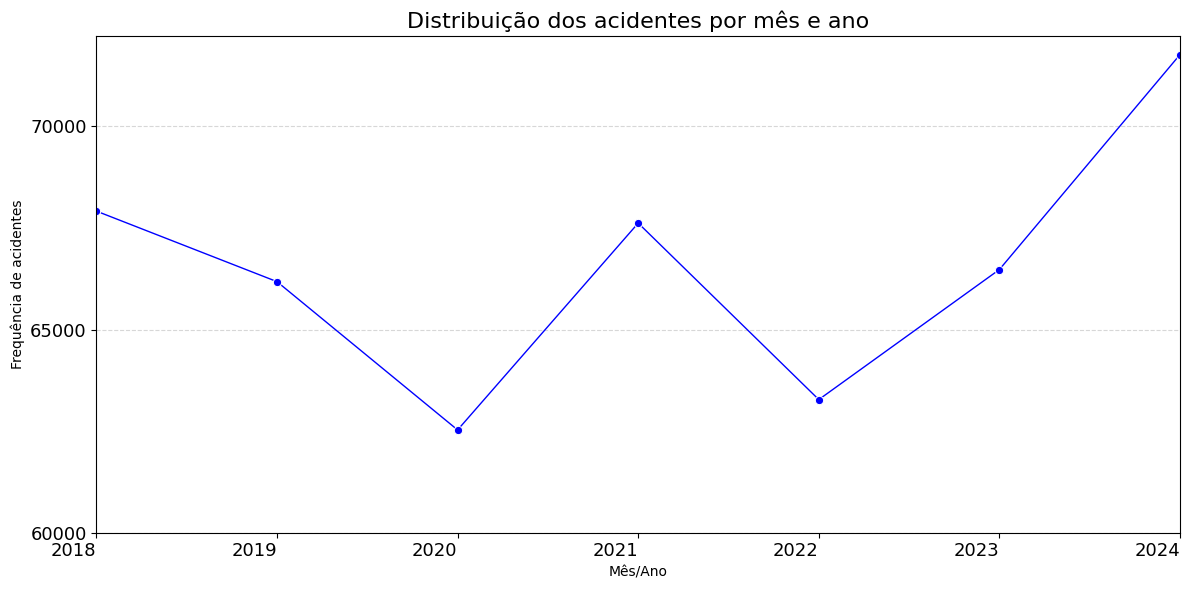

In [98]:
from matplotlib.ticker import MultipleLocator

# Gera nova coluna no formato "YYYY-MM"
df = df_accidents.copy()
df["mes_ano"] = df["mes_ano"].dt.strftime('%Y')

# Agrupa e conta a quantidade de acidentes por mês/ano
df_grouped = df.groupby("mes_ano").size().reset_index(name="frequencia")

# Ordena por data
df_grouped = df_grouped.sort_values("mes_ano")
print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

# Plota o gráfico de linha
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_grouped,
    x="mes_ano",
    y="frequencia",
    marker="o",
    color="blue",
    linewidth=1
)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Distribuição dos acidentes por mês e ano", fontsize=16)
plt.ylabel("Frequência de acidentes")
plt.xlabel("Mês/Ano")
plt.ylim(bottom=60000)
plt.gca().yaxis.set_major_locator(MultipleLocator(5000))
plt.xticks(rotation=0, ha="right")
plt.margins(x=0)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.tight_layout()
plt.show()

#### Lendo a nova base de dados após o tratamento do ano de 2021

In [99]:
# df_accidents = pd.read_csv(
#     "analysis/datatran2018_2024_v2.csv",
#     parse_dates=["mes_ano"]
# )
# df_accidents.reset_index(drop=True, inplace=True)

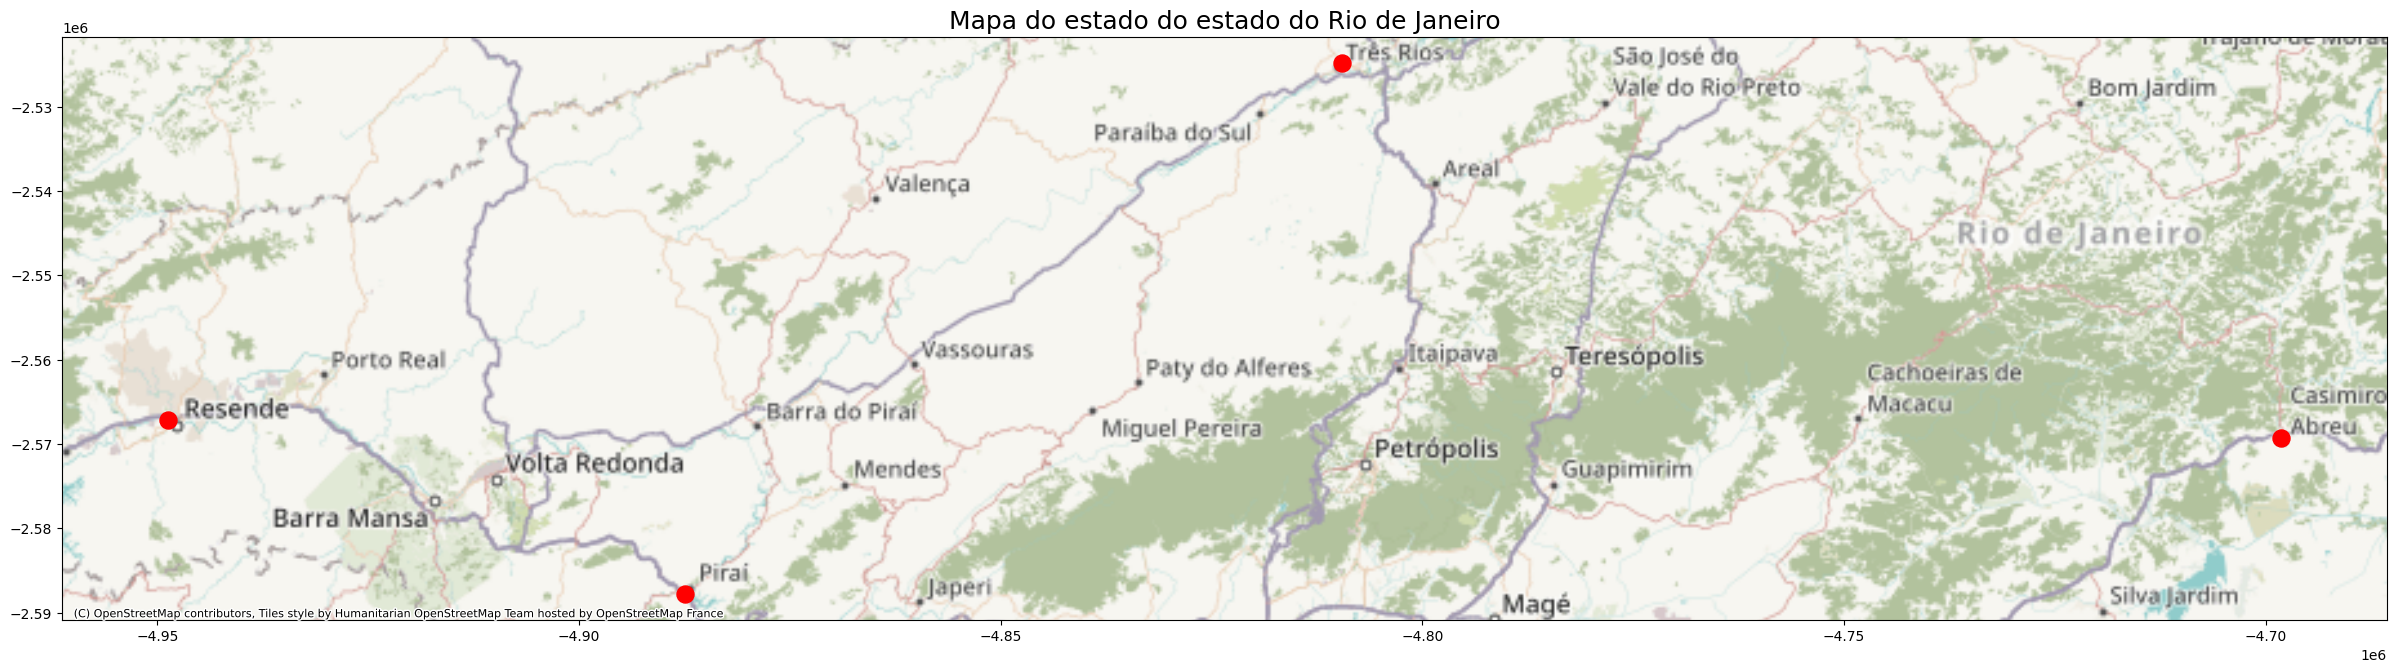

In [100]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# Exemplo de dados com latitudes e longitudes
data = {
    'nome': ['Piraí (RJ)', 'Casimiro de Abreu (RJ)', 'Resende (RJ)', 'Três Rios (RJ)'],
    'latitude': [-22.6335, -22.4808, -22.4627, -22.1111],
    'longitude': [-43.9046, -42.2039, -44.4556, -43.2042]
}

# Cria um DataFrame do pandas
df = pd.DataFrame(data)

# Cria uma coluna de geometria com pontos
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Cria um GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Define o sistema de referência de coordenadas (CRS) para WGS84 (GPS)
gdf.set_crs(epsg=4326, inplace=True)

# # Plota os pontos em um gráfico
# gdf.plot(marker='o', color='red', markersize=50)

# Transforma para projeção web mercator (EPSG:3857)
gdf_webmerc = gdf.to_crs(epsg=3857)

ax = gdf_webmerc.plot(marker='o', color='red', markersize=150, figsize=(30,30))

# Adiciona o mapa base
ctx.add_basemap(ax)

plt.title('Mapa do estado do estado do Rio de Janeiro', fontsize=18)
plt.show()



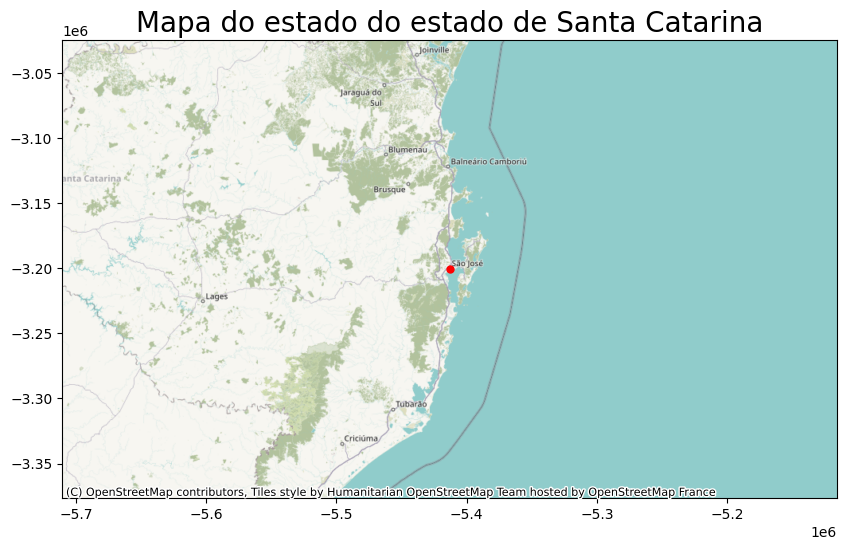

In [101]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# Exemplo de dados com latitudes e longitudes
data = {
    'nome': ['São José (Barreiros)'],
    'latitude': [-27.6153],
    'longitude': [-48.6267]
}

# Cria um DataFrame do pandas
df = pd.DataFrame(data)

# Cria uma coluna de geometria com pontos
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Cria um GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Define o sistema de referência de coordenadas (CRS) para WGS84 (GPS)
gdf.set_crs(epsg=4326, inplace=True)

# # Plota os pontos em um gráfico
# gdf.plot(marker='o', color='red', markersize=50)

# Transforma para projeção web mercator (EPSG:3857)
gdf_webmerc = gdf.to_crs(epsg=3857)

ax = gdf_webmerc.plot(marker='o', color='red', markersize=25, figsize=(10,10))

# Adiciona o mapa base
ctx.add_basemap(ax)

plt.title('Mapa do estado do estado de Santa Catarina', fontsize=20)
plt.show()

#### Análise univariada da coluna tipo_data, agrupando por Feriado ou Dia útil

                   tipo_data  frequencia
0   Dia da consciência negra         152
1                    Finados        1051
2          Sexta-feira Santa        1117
3                      Natal        1134
4                   Carnaval        1179
5             Corpus Christi        1199
6                     Páscoa        1210
7    Independência do Brasil        1220
8    Nossa Senhora Aparecida        1231
9   Proclamação da República        1247
10           Dia do trabalho        1249
11                Tiradentes        1255
12  Confraternização mundial        1410
13                  Dia útil      413913


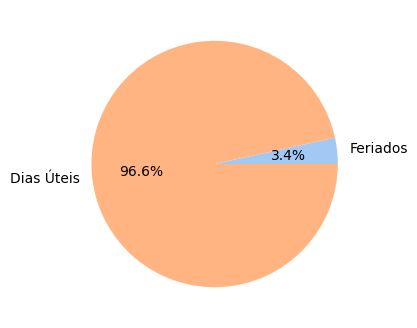

In [102]:
df_copy = df_accidents.copy()
df_copy.dropna(inplace=True)
df_copy = df_copy["tipo_data"].value_counts().sort_values().reset_index()
df_copy.columns = ["tipo_data", "frequencia"]
print(df_copy)

df = pd.DataFrame(
    {
        "categoria":
            ["Feriados", "Dias Úteis"],
        "frequencia": [
            df_copy[df_copy["tipo_data"] != "Dia útil"]["frequencia"].sum(),
            df_copy[df_copy["tipo_data"] == "Dia útil"]["frequencia"].sum()
                ]
    }
)

draw_pie(
    df=df["frequencia"],
    labels=df["categoria"],
    figsize=(4, 4)
)

#### Analisando os feriados com mais ocorrências de acidentes

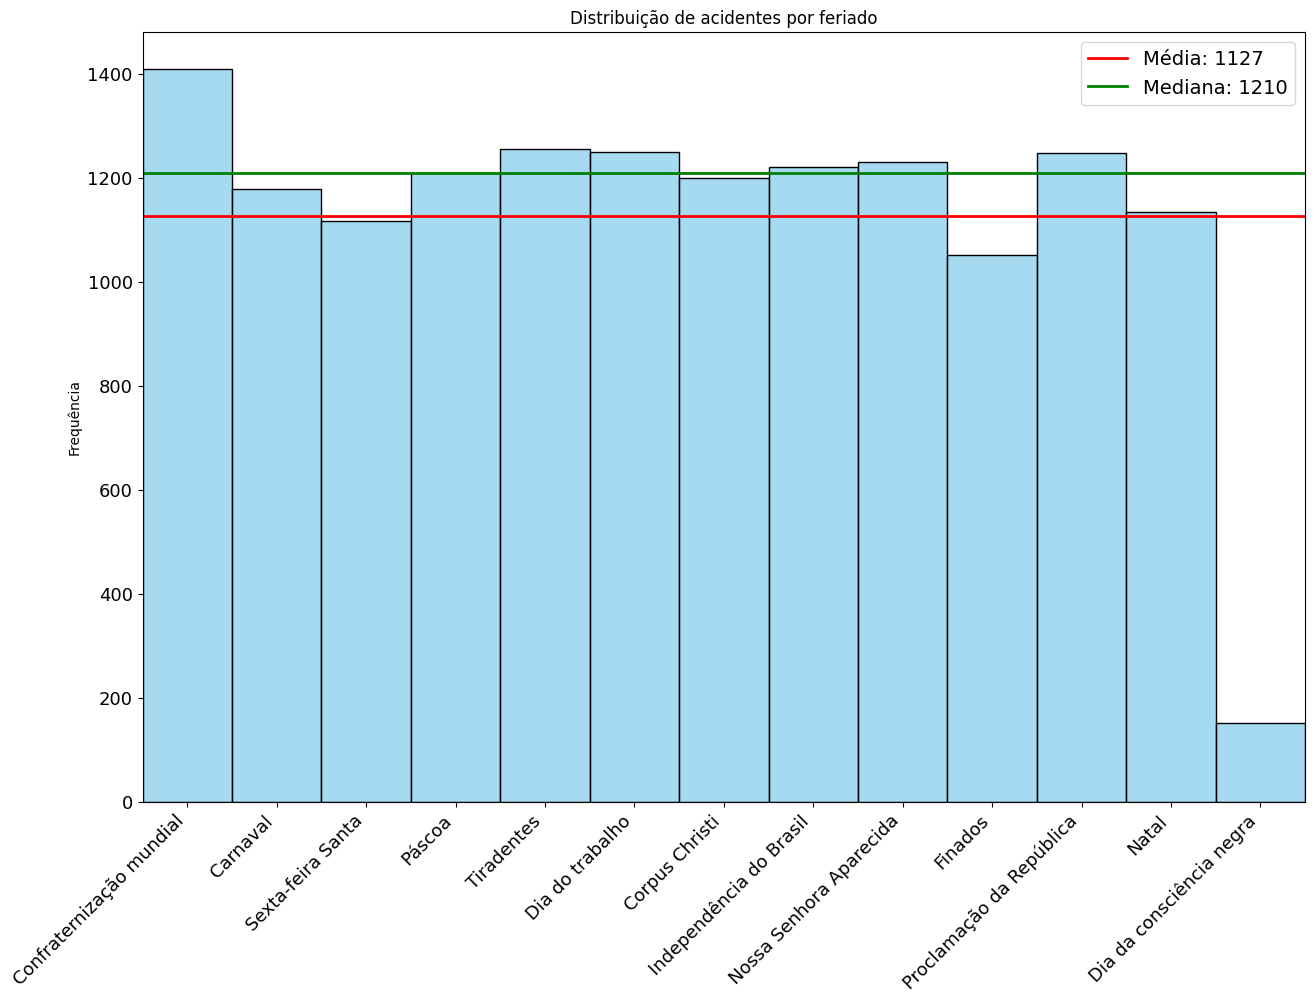

In [103]:
df = df_accidents.copy()
df = df.dropna(subset="tipo_data")
df = df_accidents[df_accidents["tipo_data"] != "Dia útil"]
draw_histplot(
    df=df["tipo_data"],
    title="Distribuição de acidentes por feriado",
    orient="h",
    width=15,
    height=10,
    bins=20,
    rotation=True,
    center_x_label=False
)

#### Análise da distribuição de acidentes de acordo com o dia da semana

In [104]:
df = df_accidents.copy()
df = df.dropna(subset="dia_semana")

# Agrupa e conta a quantidade de acidentes por dia_semana
df_grouped = df.groupby("dia_semana").size().reset_index(name="frequencia")

# Ordena por data
df_grouped = df_grouped.sort_values("dia_semana")
print(df_grouped)
print(f'Média: {df_grouped["frequencia"].mean():.0f}')
print(f'Mediana: {df_grouped["frequencia"].median():.0f}')
print(f'Moda: {df_grouped["frequencia"].mode().iloc[0]:.0f}')

      dia_semana  frequencia
0        Domingo       70655
1   Quarta-feira       54124
2   Quinta-feira       55705
3  Segunda-feira       58455
4    Sexta-feira       66024
5         Sábado       70489
6    Terça-feira       53115
Média: 61224
Mediana: 58455
Moda: 53115


#### Análise da distribuição de acidentes por horário

horario
00     8972
01     7778
02     7014
03     7276
04     9021
05    12615
06    18527
07    25672
08    21347
09    17969
10    17940
11    18834
12    17758
13    18967
14    20762
15    22231
16    24318
17    28449
18    32753
19    27443
20    20123
21    16678
22    14460
23    11660
Name: count, dtype: int64


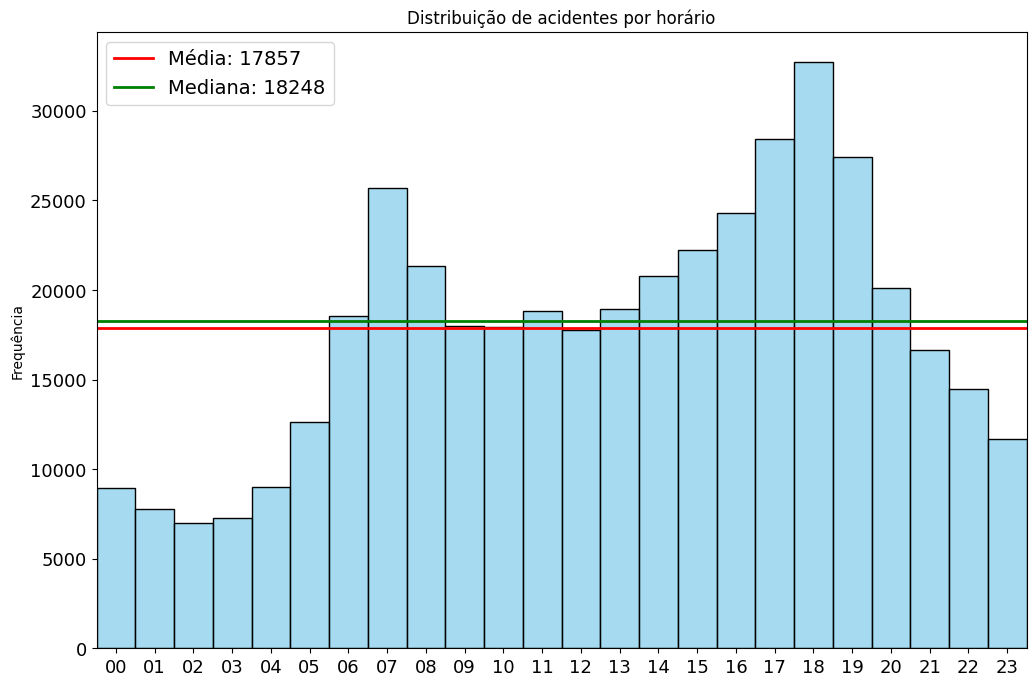

Média: 17857
Mediana: 18248


In [105]:
df = df_accidents.copy()
df = df.dropna(subset="horario")
df = df[df["horario"].notna()]["horario"]
df = pd.to_datetime(df, format="%H:%M:%S").dt.hour.astype(str).str.zfill(2)
print(df.value_counts().sort_index(ascending=True))
draw_histplot(
    df=df.sort_values(),
    title="Distribuição de acidentes por horário",
    orient="h",
    width=12,
    height=8
)
print(f'Média: {df.value_counts().mean():.0f}')
print(f'Mediana: {df.value_counts().median():.0f}')

#### Análise da distribuição de acidentes por fase do dia

    fase_dia  frequencia
0  Madrugada       52676
1      Manhã      120289
2      Noite      123117
3      Tarde      132485


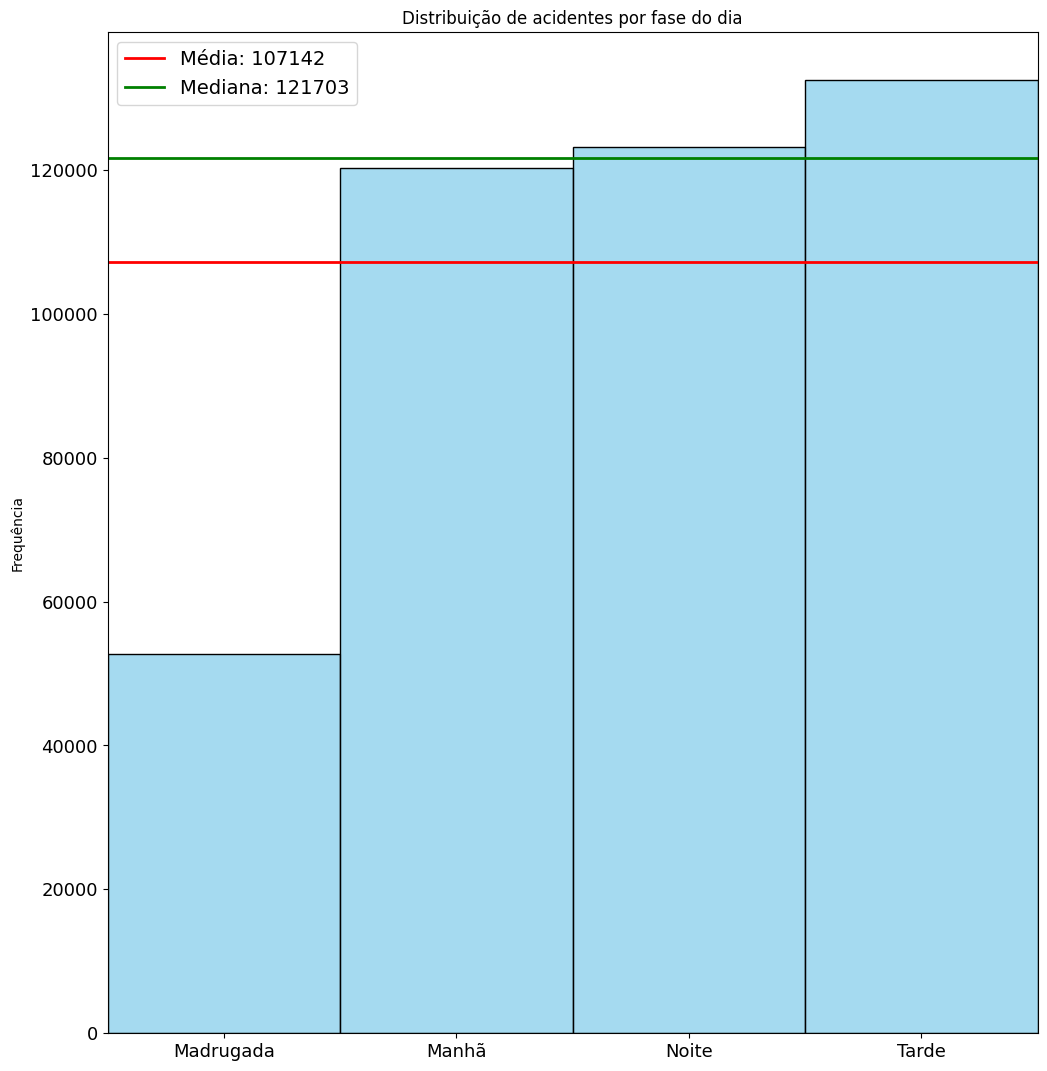

In [106]:
df = df_accidents.copy()
df = df.dropna(subset="fase_dia")
# Agrupa e conta a quantidade de acidentes por dia_semana
df_grouped = df.groupby("fase_dia").size().reset_index(name="frequencia")

# Ordena por data
df_grouped = df_grouped.sort_values("fase_dia")
print(df_grouped)
draw_histplot(
    df=df["fase_dia"].sort_values(),
    title="Distribuição de acidentes por fase do dia",
    orient="h",
    width=12,
    height=13,
)

#### Análise da distribuição de acidentes por condição meteorológica

  condicao_metereologica  frequencia
0                  Chuva       47031
1              Céu Claro      261464
2         Garoa/Chuvisco       15204
3       Nevoeiro/Neblina        3635
4                Nublado       71427
5                    Sol       28984
6                  Vento         822


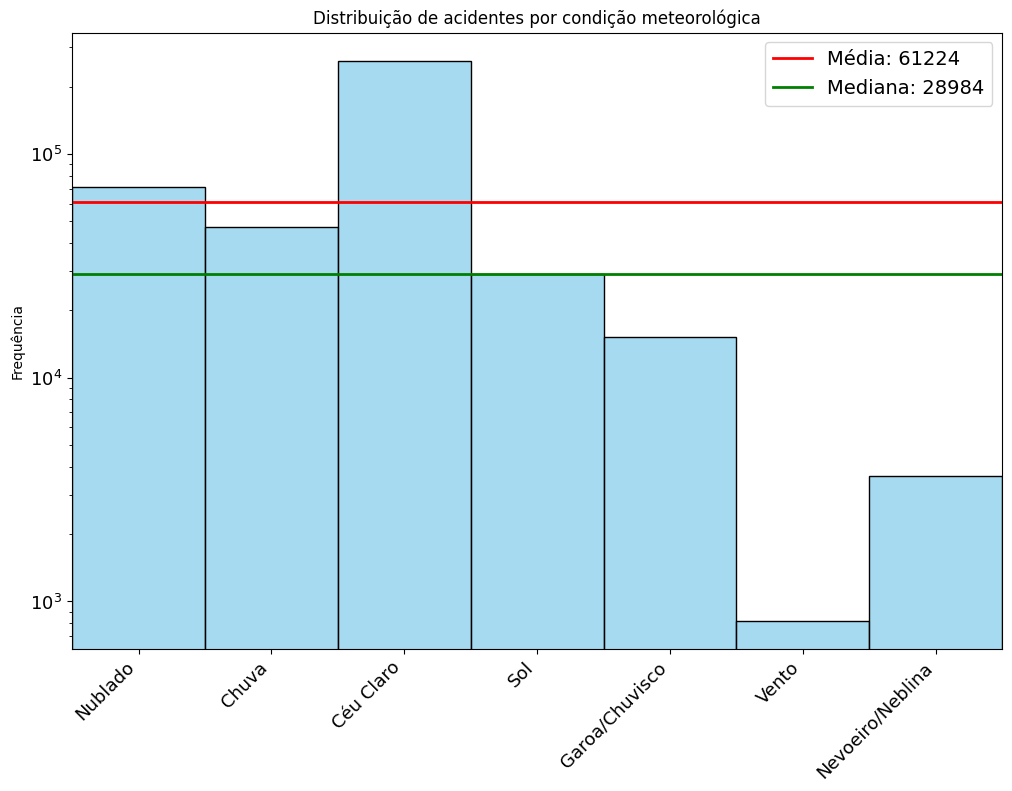

In [107]:
df = df_accidents.copy()
df = df.dropna(subset="condicao_metereologica")

# Agrupa e conta a quantidade de acidentes por dia_semana
df_grouped = df.groupby("condicao_metereologica").size().reset_index(name="frequencia")

# Ordena por data
df_grouped = df_grouped.sort_values("condicao_metereologica")
print(df_grouped)



draw_histplot(
    df=df["condicao_metereologica"].sort_index(),
    title="Distribuição de acidentes por condição meteorológica",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    center_x_label=False,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por estado

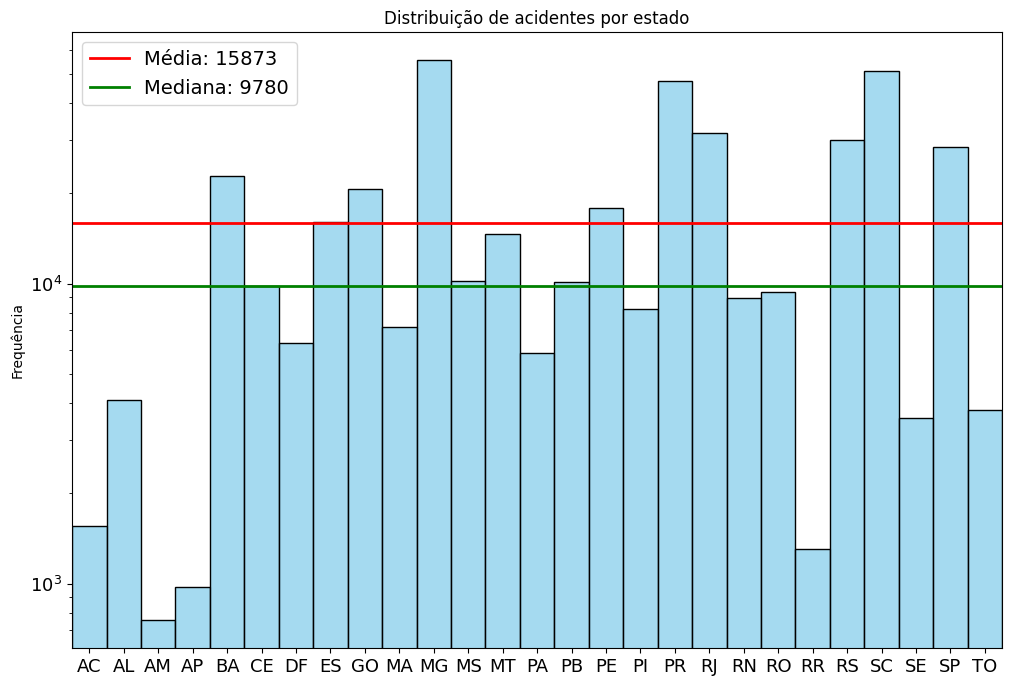

In [108]:
df = df_accidents.copy()
df = df.dropna(subset="uf")
draw_histplot(
    df=df["uf"].sort_values(ascending=True),
    title="Distribuição de acidentes por estado",
    orient="h",
    width=12,
    height=8,
    set_yscale=True
)

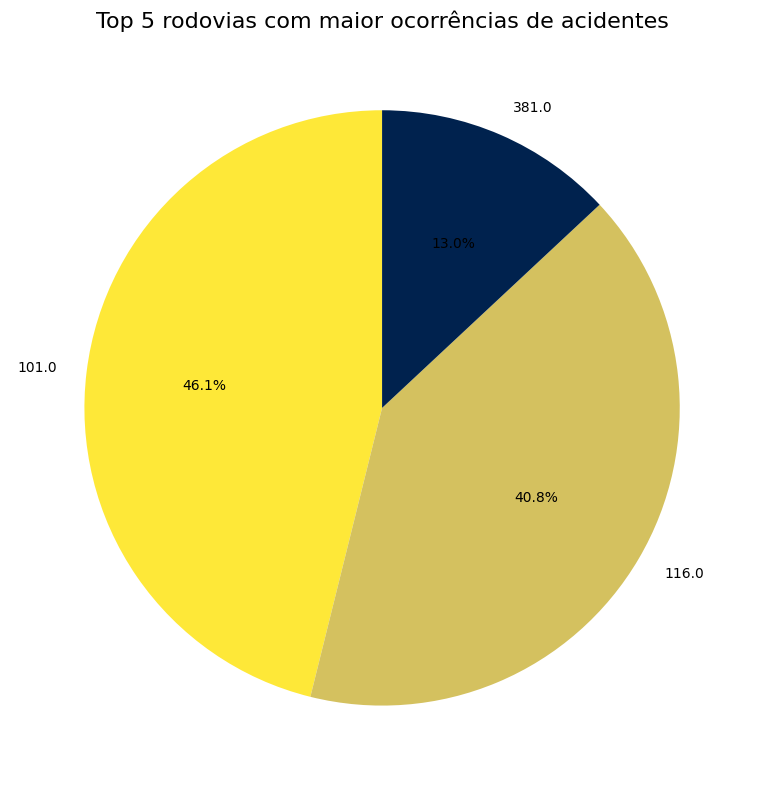

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Series com as 3 BRs mais frequentes
df_top_br = df_accidents["br"].value_counts().nlargest(3)

# Converte para DataFrame
df_plot = df_top_br.reset_index()
df_plot.columns = ["Rodovia", "Frequência"]

# Normaliza os valores para variar de 0 a 1 (para usar no colormap)
norm = plt.Normalize(df_plot["Frequência"].min(), df_plot["Frequência"].max())

# Mapeia cada frequência para uma cor no gradiente viridis
cmap = plt.cm.cividis
colors = cmap(norm(df_plot["Frequência"].values))

# Plot do gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(
    df_plot["Frequência"],
    labels=df_plot["Rodovia"],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

plt.title("Top 5 rodovias com maior ocorrências de acidentes", fontsize=16)
plt.tight_layout()
plt.show()



#### Análise da distribuição de maior número de acidentes por rodovia (radiais)

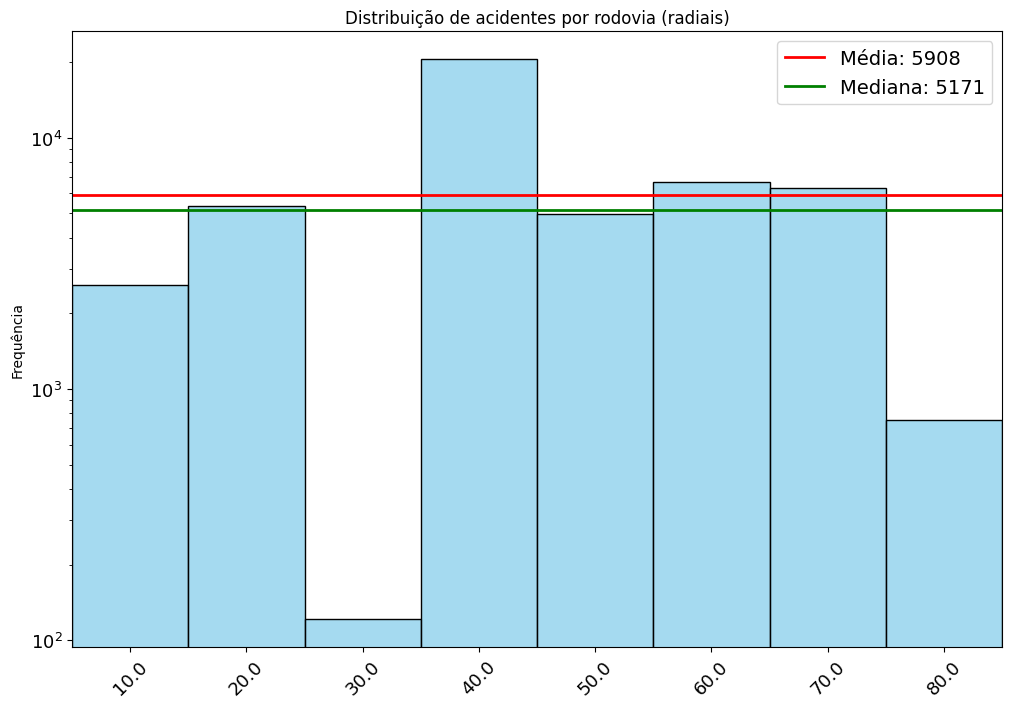

In [110]:
min_value, max_value = 10, 99
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (radiais)",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (longitudinais)

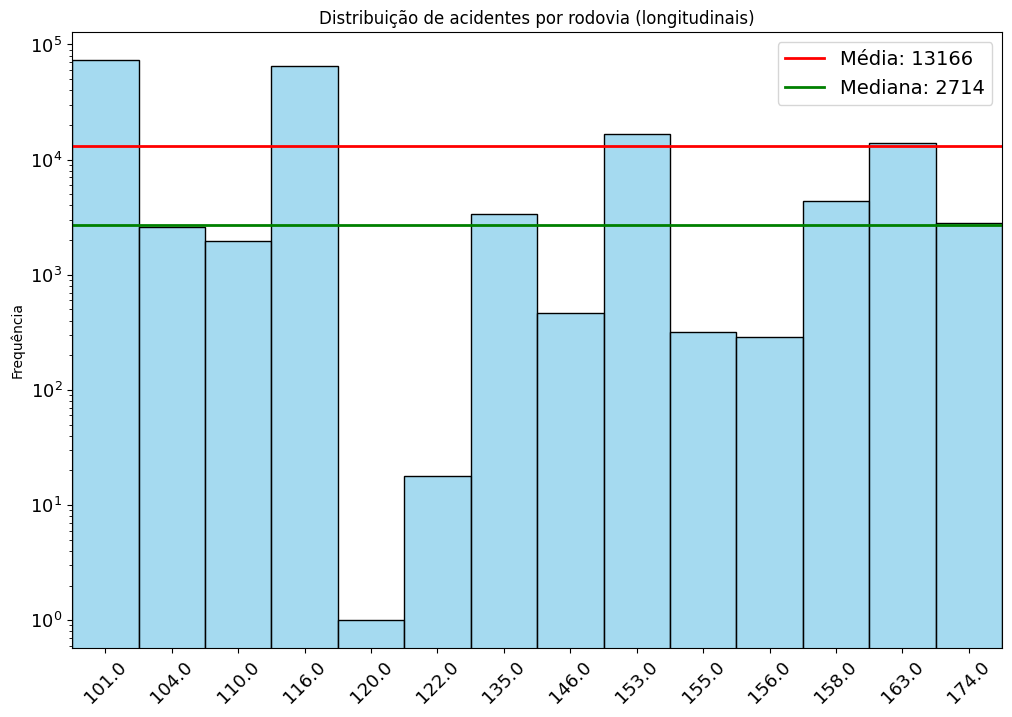

In [111]:
min_value, max_value = 100, 199
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (longitudinais)",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (transversais)

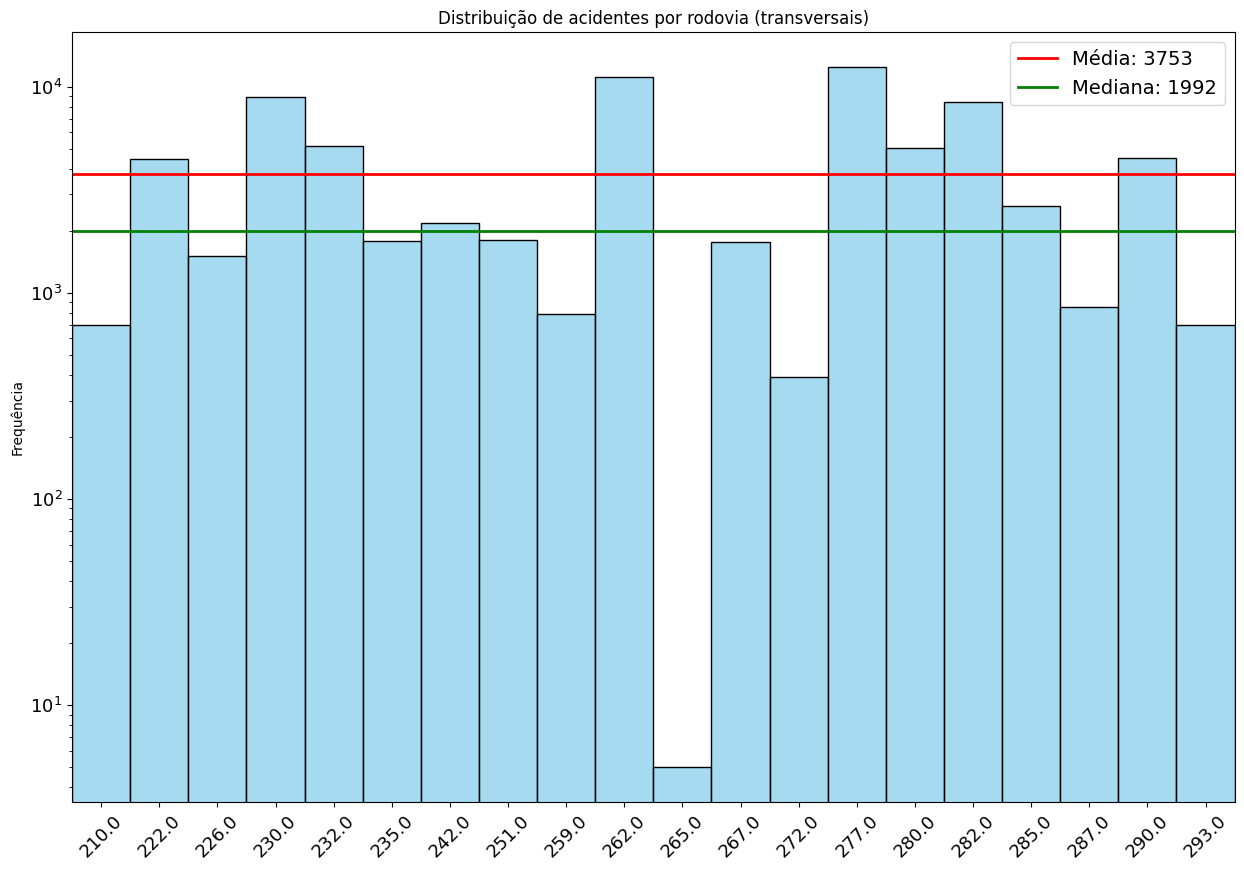

In [112]:
min_value, max_value = 200, 299
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (transversais)",
    orient="h",
    width=15,
    height=10,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (diagonais)

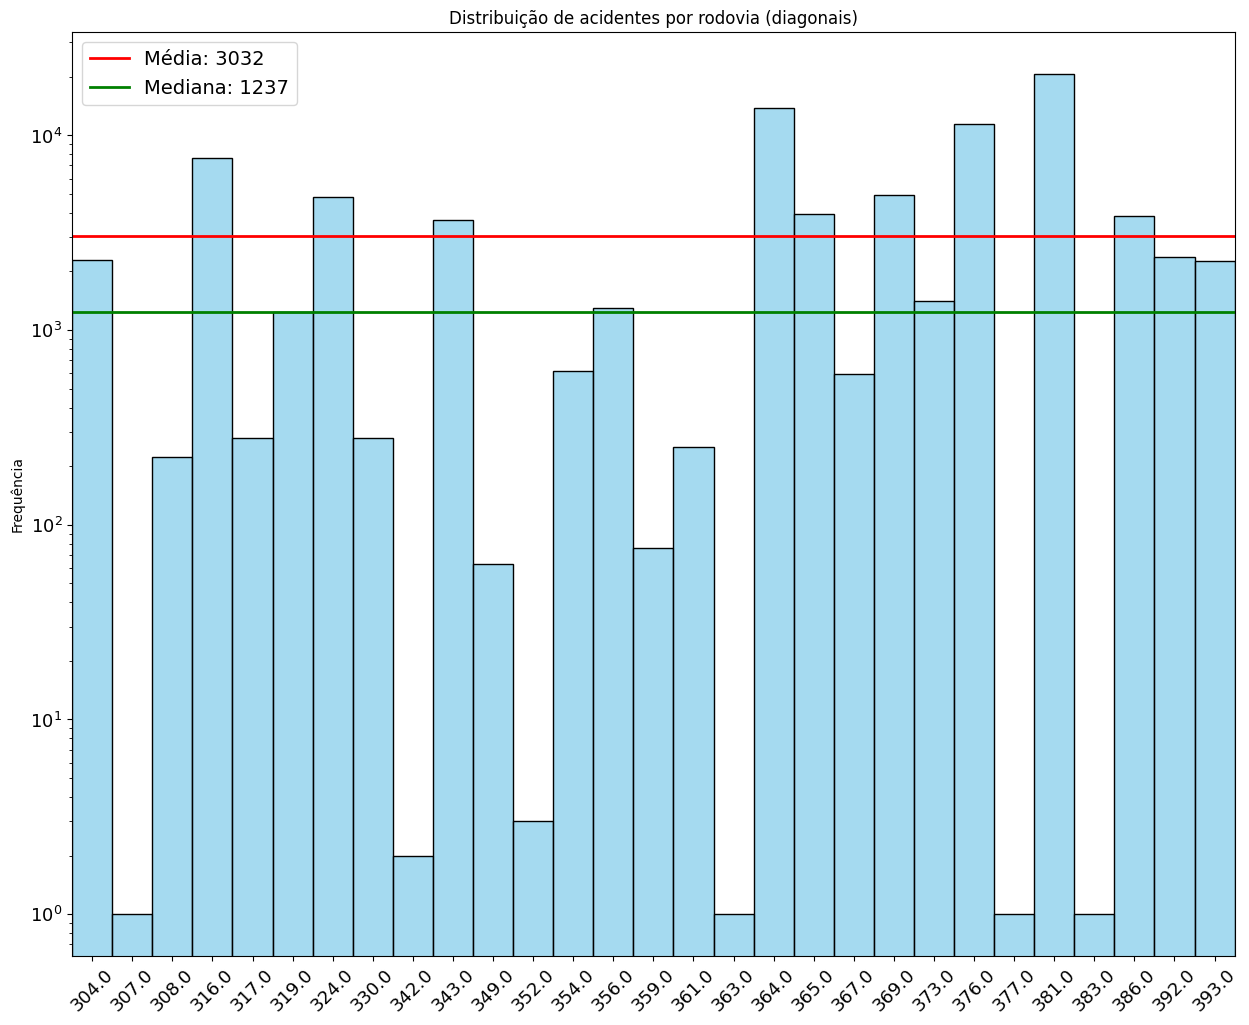

In [113]:
min_value, max_value = 300, 399
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (diagonais)",
    orient="h",
    width=15,
    height=12,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (de ligação)

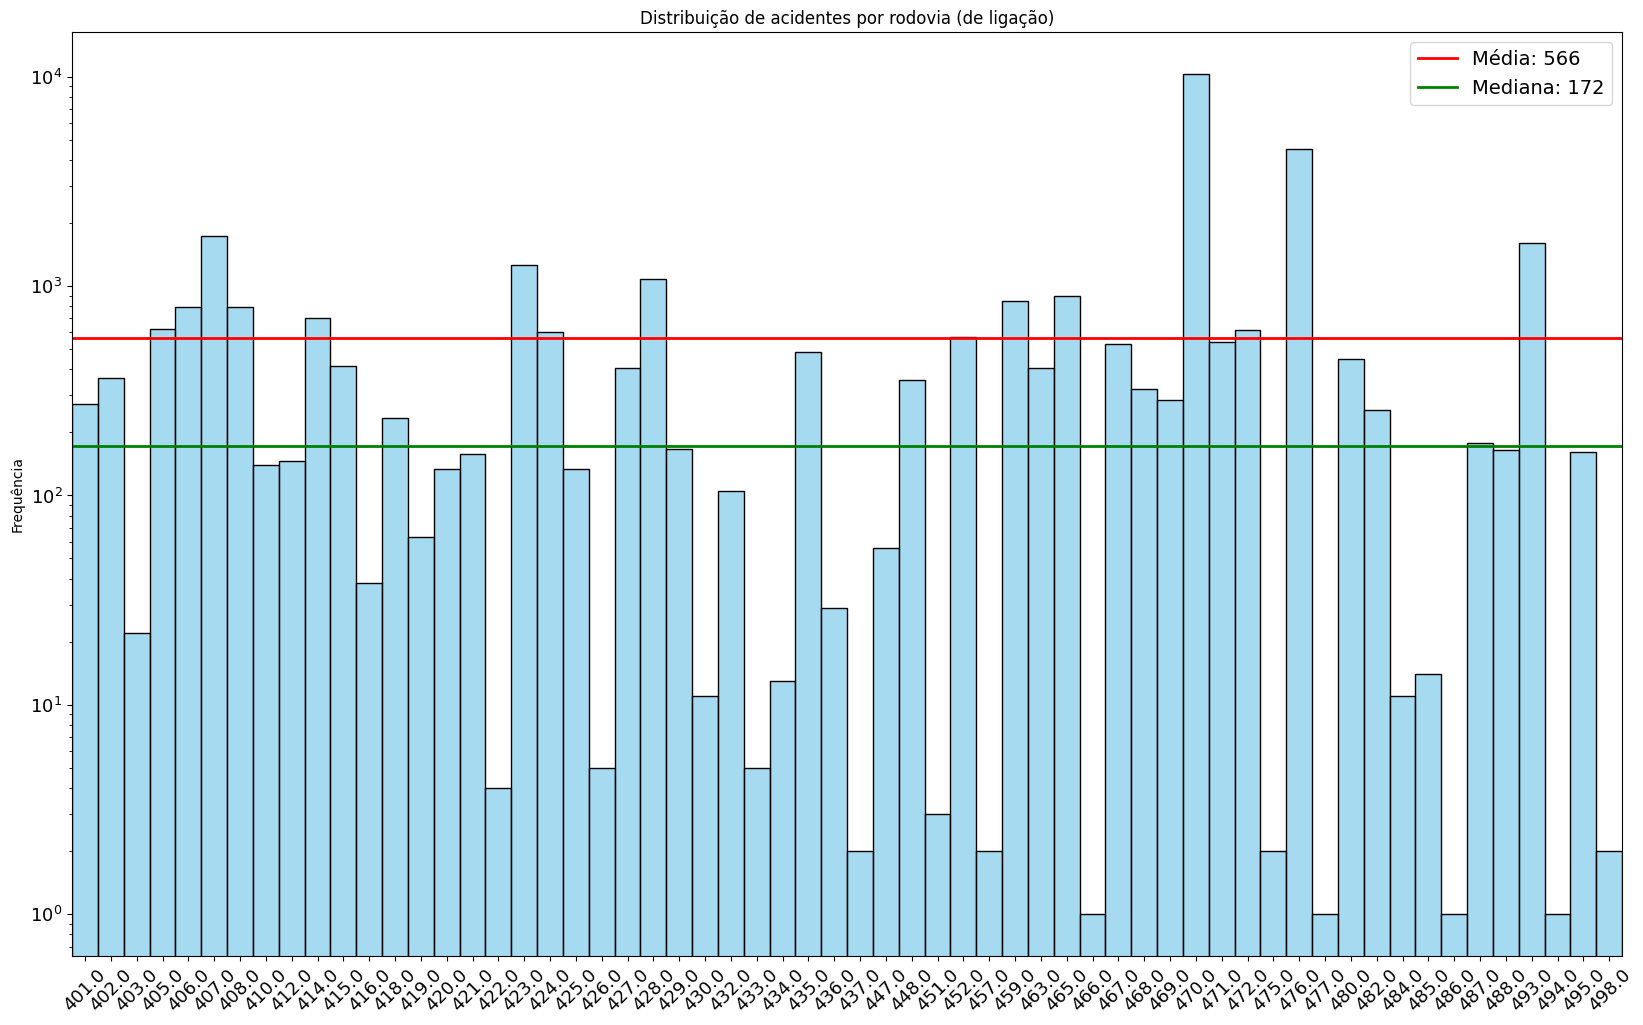

In [114]:
min_value, max_value = 400, 499
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (de ligação)",
    orient="h",
    width=20,
    height=12,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por uso do solo

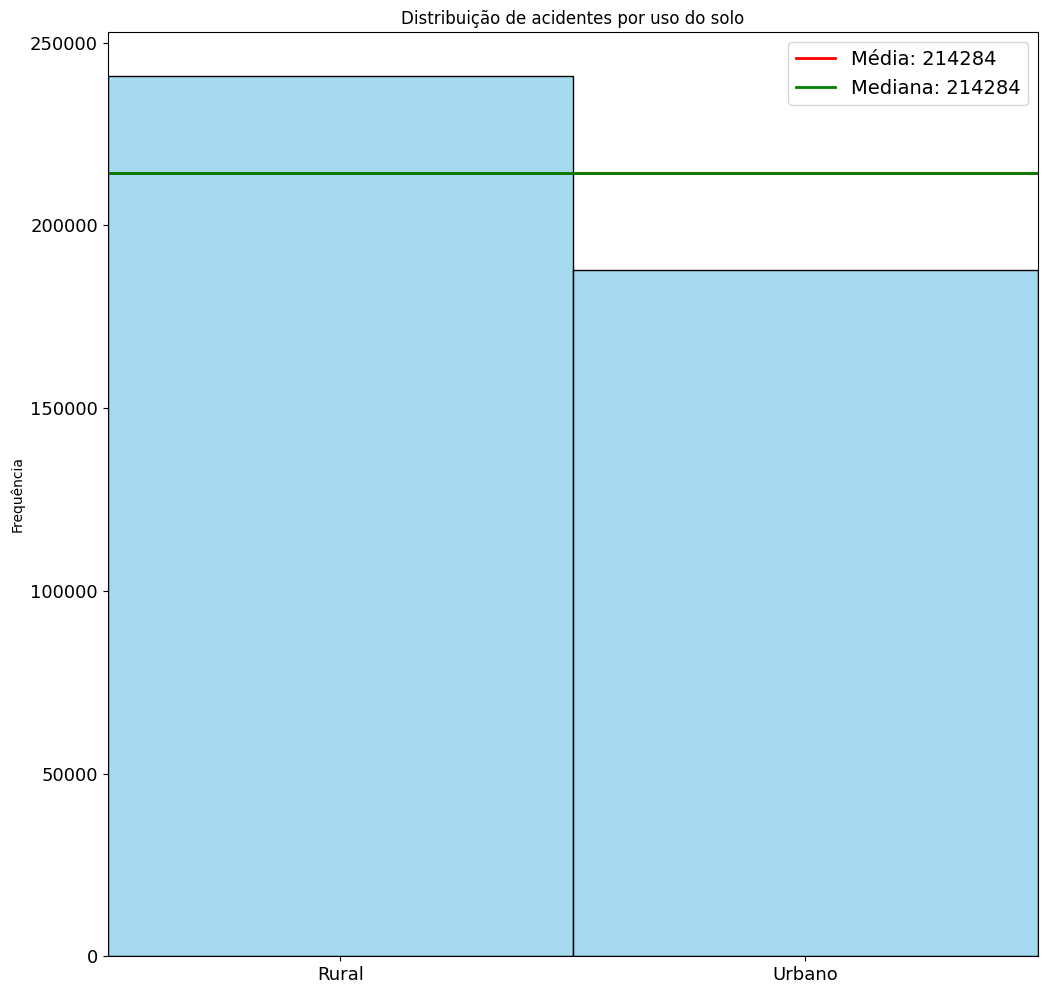

In [115]:
df = df_accidents.copy()
df = df.dropna(subset="uso_solo")
draw_histplot(
    df=df["uso_solo"].sort_values().astype(str),
    title="Distribuição de acidentes por uso do solo",
    orient="h",
    width=12,
    height=12
)

#### Análise da distribuição de maior número de acidentes por tipo de pista

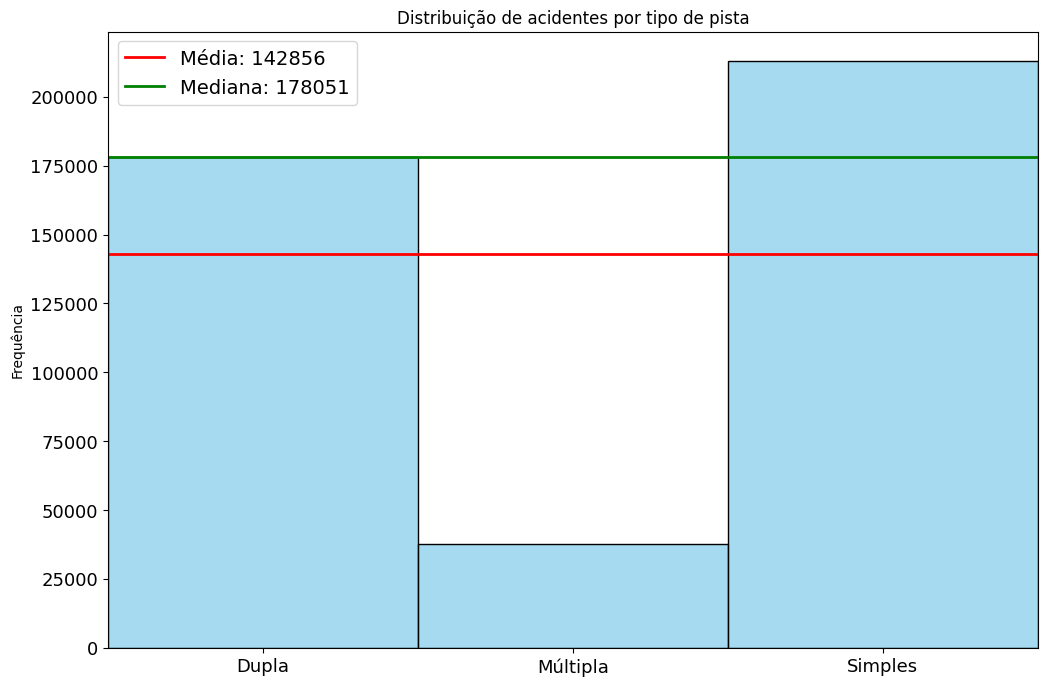

In [116]:
df = df_accidents.copy()
df = df.dropna(subset="tipo_pista")

draw_histplot(
    df=df["tipo_pista"].sort_values().astype(str),
    title="Distribuição de acidentes por tipo de pista",
    orient="h",
    width=12,
    height=8
)

#### Análise da distribuição de maior número de acidentes por sentido da via

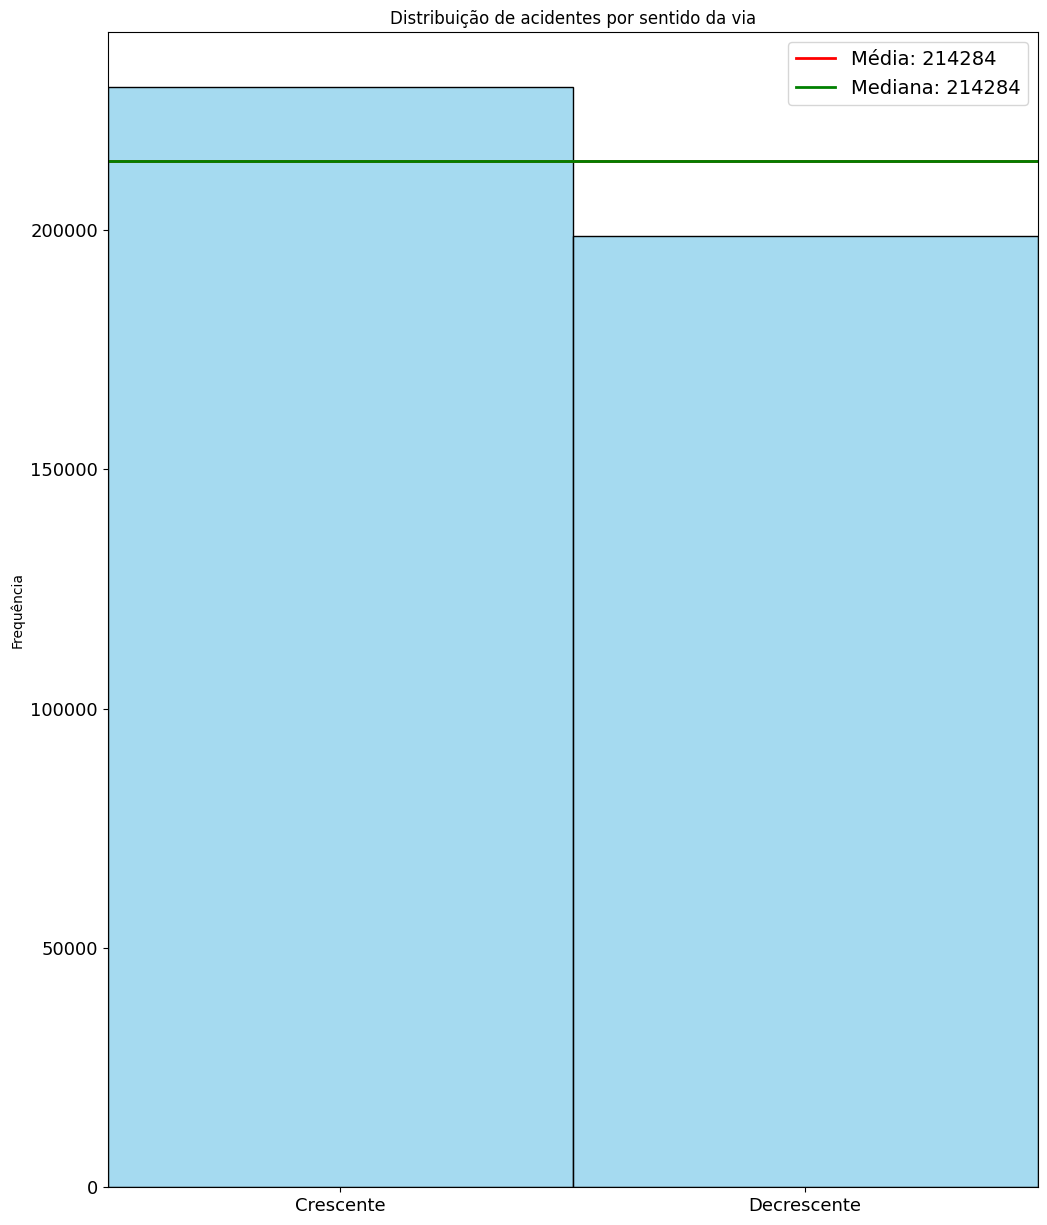

In [117]:
df = df_accidents.copy()
df = df.dropna(subset="sentido_via")
draw_histplot(
    df=df["sentido_via"].sort_values().astype(str),
    title="Distribuição de acidentes por sentido da via",
    orient="h",
    width=12,
    height=15
)

#### Análise da distribuição de maior número de acidentes por tipo de acidente

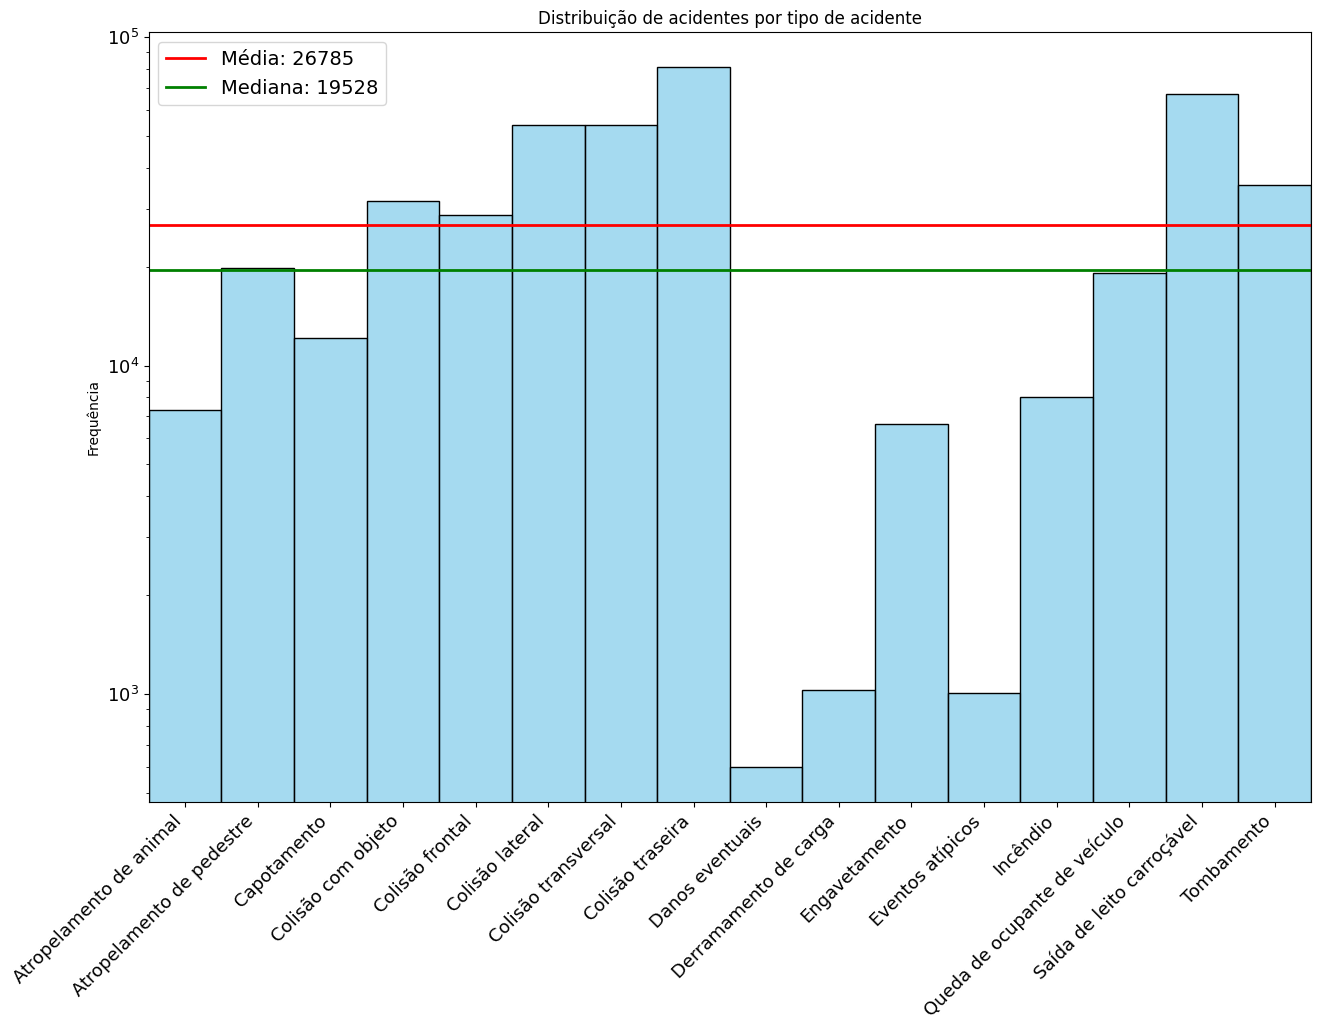

In [118]:
df = df_accidents.copy()
df = df.dropna(subset="tipo_acidente")

draw_histplot(
    df=df["tipo_acidente"].sort_values().astype(str),
    title="Distribuição de acidentes por tipo de acidente",
    orient="h",
    width=15,
    height=10,
    rotation=True,
    set_yscale=True,
    center_x_label=False
)

#### Análise da distribuição de maior número de acidentes por causa de acidente

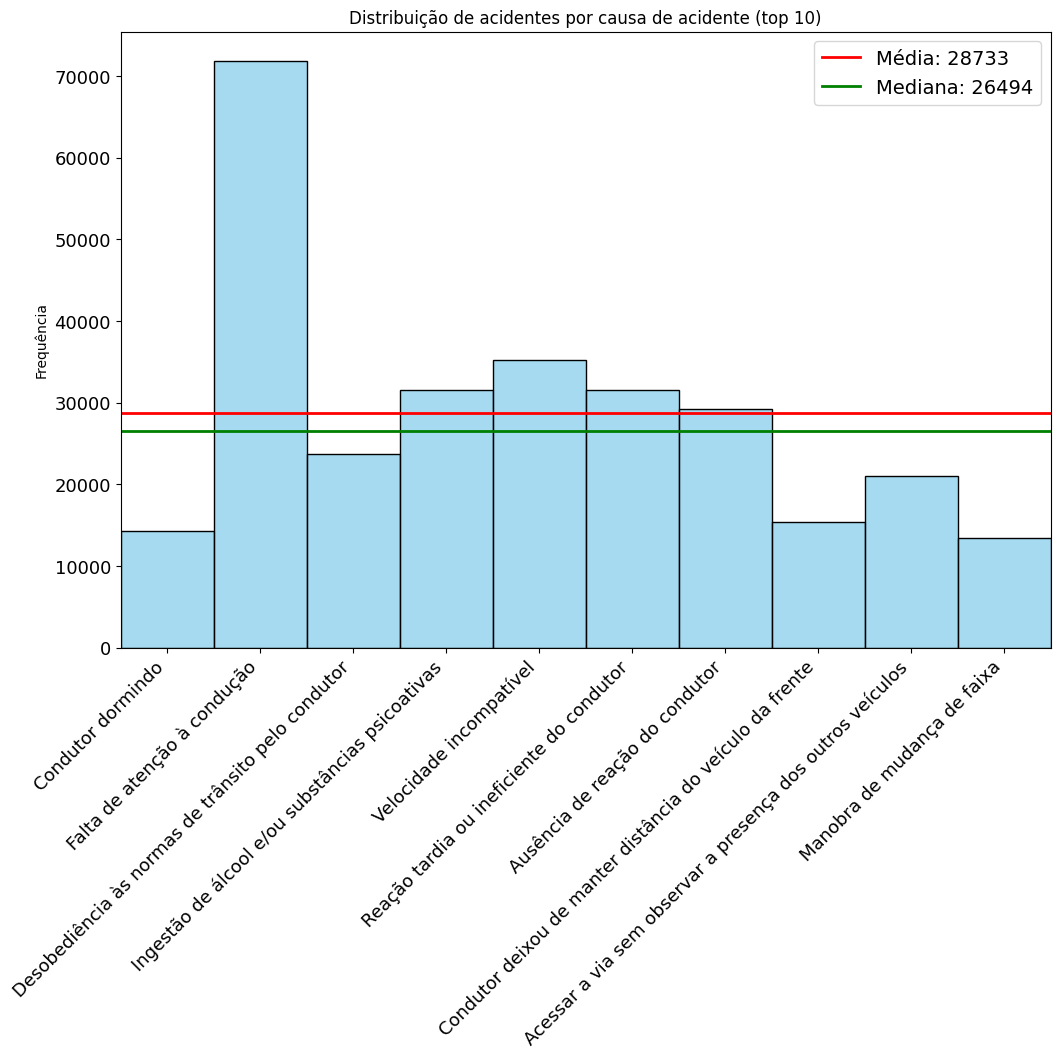

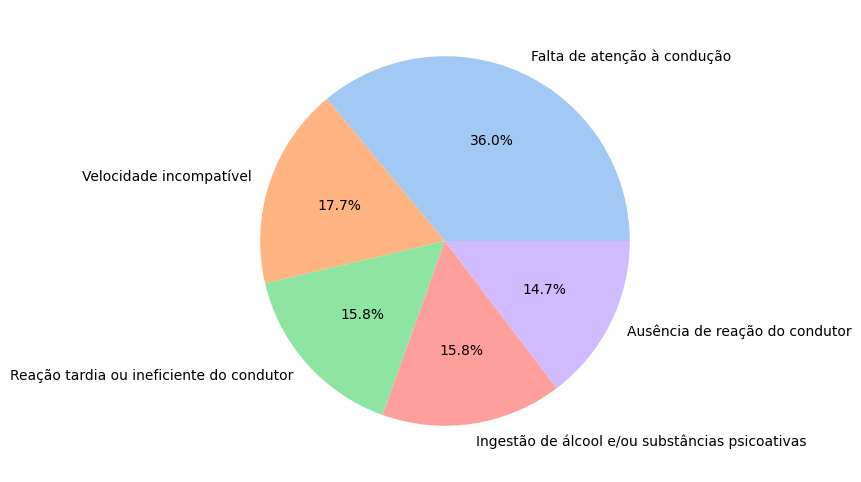

In [119]:
df = df_accidents.copy()
df = df.dropna(subset="causa_acidente")

df_top5 = df[df["causa_acidente"].isin(
    df["causa_acidente"].value_counts().nlargest(10).index)]

draw_histplot(
    df=df_top5["causa_acidente"],
    title="Distribuição de acidentes por causa de acidente (top 10)",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    center_x_label=False
)

df = df_accidents.copy()
df = df.dropna(subset="causa_acidente")
df = df["causa_acidente"].value_counts().reset_index()
df.columns = ["causa_acidente", "frequencia"]
df = df.head(5)


draw_pie(
    df=df["frequencia"],
    labels=df["causa_acidente"],
    figsize=(6, 6)
)

#### Análise da distribuição de maior número de acidentes por classificação de acidente

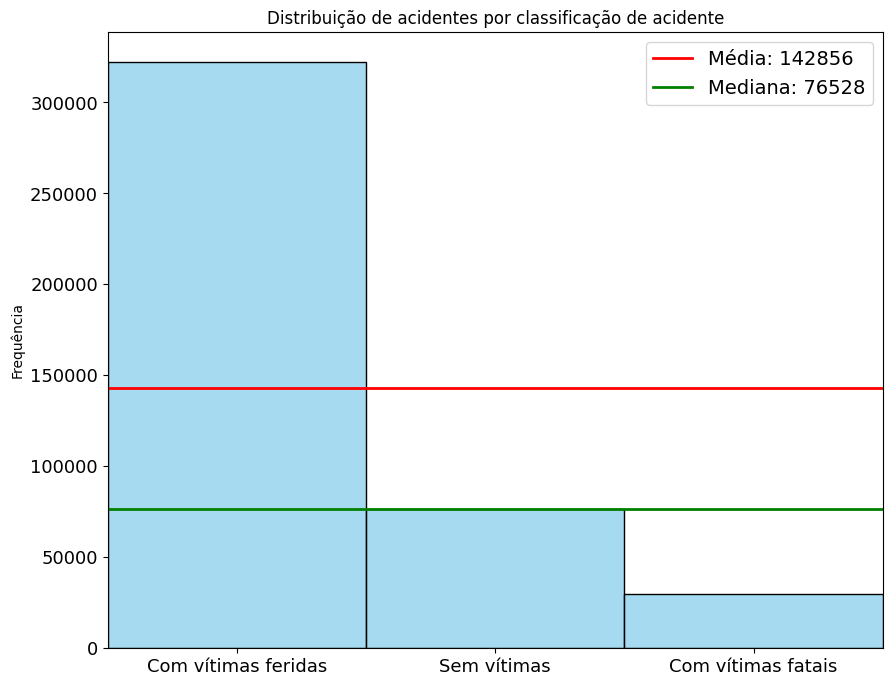

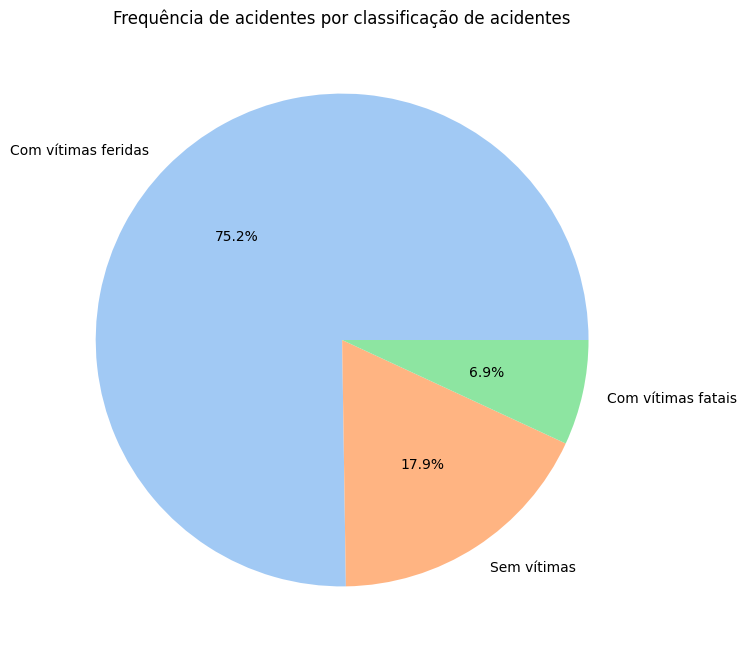

In [120]:
df = df_accidents.copy()
df = df.dropna(subset="classificacao_acidente")

draw_histplot(
    df=df["classificacao_acidente"],
    title="Distribuição de acidentes por classificação de acidente",
    orient="h",
    width=10,
    height=8
)

df = df_accidents.copy()
df = df["classificacao_acidente"].value_counts().reset_index()
df.columns = ["classificacao_acidente", "frequencia"]

draw_pie(
    df=df["frequencia"],
    labels=df["classificacao_acidente"],
    title="Frequência de acidentes por classificação de acidentes"
)

#### Análise da distribuição de acidentes por pessoas

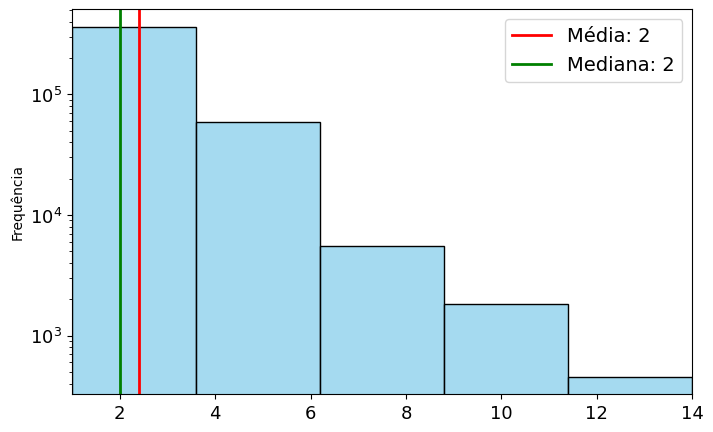

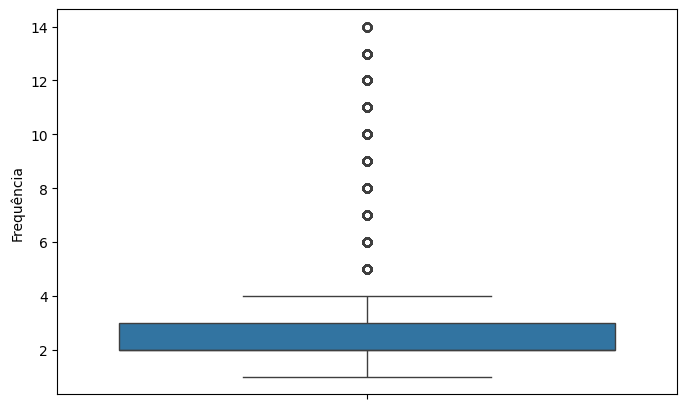

In [121]:
df = df_accidents.copy()
df = df.dropna(subset="pessoas")
draw_histplot(
    df=df["pessoas"],
    bins=5,
    title="",
    set_yscale=True
)

draw_boxplot(
    df=df["pessoas"].reset_index(),
    multipleLocator=2,
    title=""
)

#### Análise da distribuição de acidentes por veículos

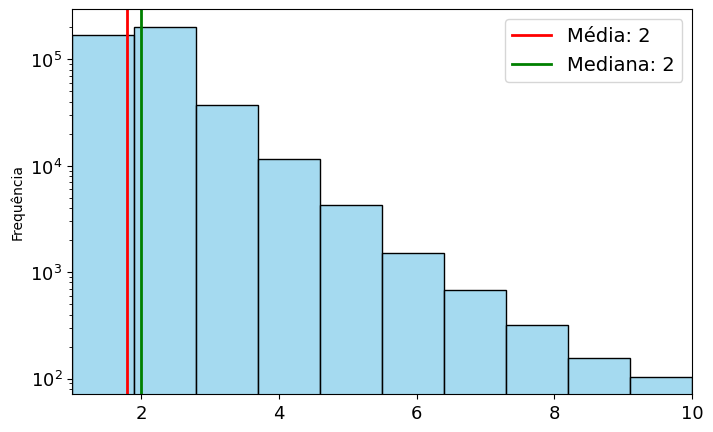

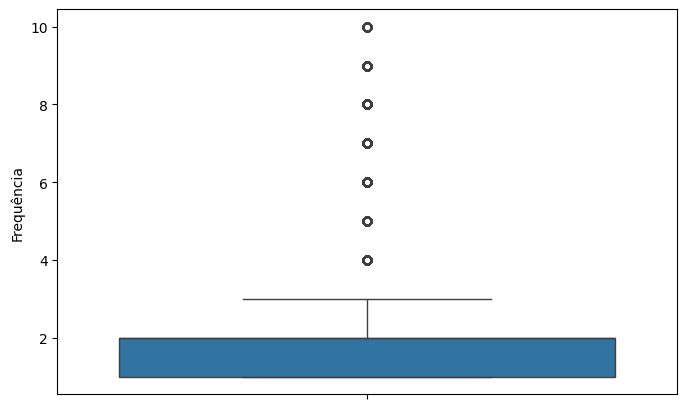

In [122]:
df = df_accidents.copy()
df = df.dropna(subset="veiculos")

draw_histplot(
    df=df["veiculos"],
    bins=10,
    title="",
    set_yscale=True
)

draw_boxplot(
    df=df["veiculos"].reset_index(),
    multipleLocator=2,
    title=""
)

## Análise bivariada

### Tipo de acidente

#### tipo_acidente x tipo_data

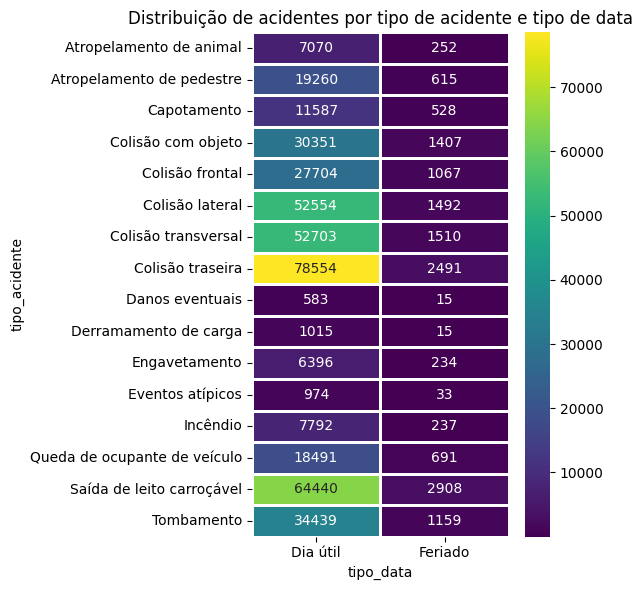

In [123]:
df = df_accidents.copy()
df.dropna(inplace=True)
df["tipo_data"] = np.where(df["tipo_data"] == "Dia útil", "Dia útil", "Feriado")
df = df.groupby(['tipo_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(6, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e tipo de data")
plt.tight_layout()
plt.show()

#### tipo_acidente x mes_ano (ano)

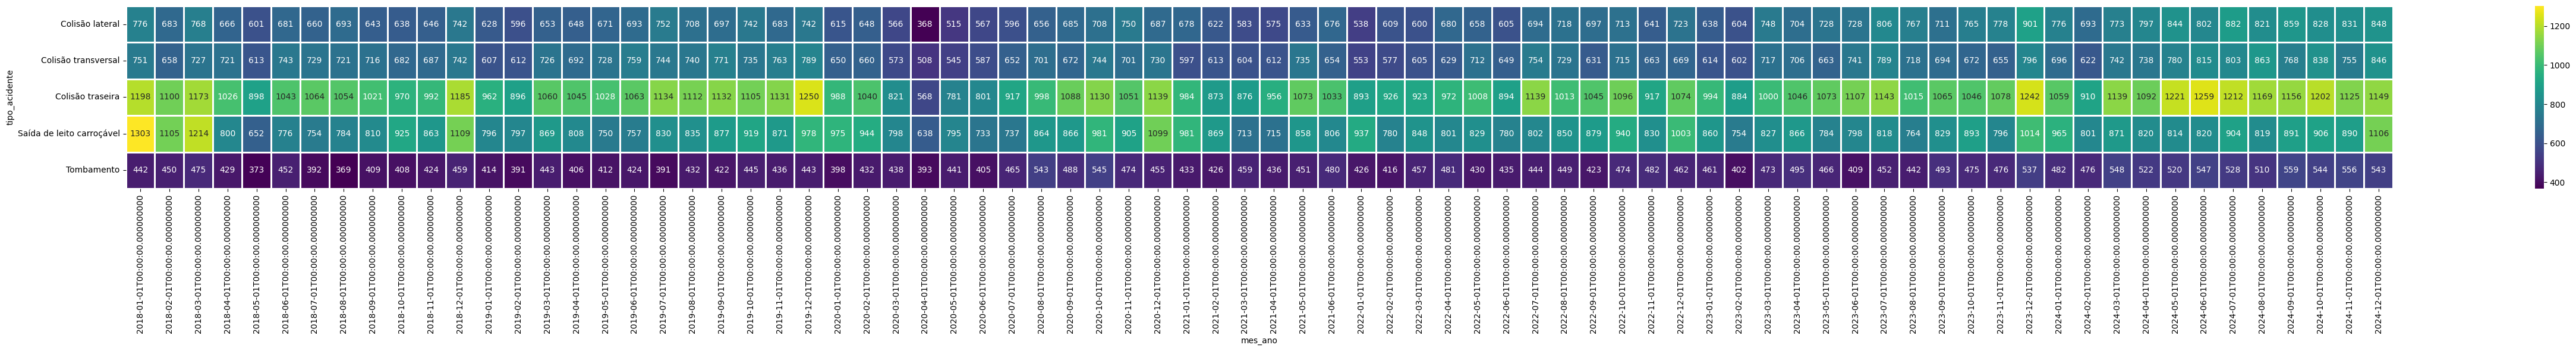

In [124]:
df = df_accidents.copy()
df = df[df["tipo_acidente"].isin([
    "Colisão traseira",
    "Saída de leito carroçável",
    "Colisão transversal",
    "Colisão lateral",
    "Tombamento"
])]
df.dropna(inplace=True)
df["mes_ano"] = df["mes_ano"]
df = df.groupby(['tipo_acidente', 'mes_ano']).size().unstack().fillna(0)
df.columns.name = "mes_ano"

plt.figure(figsize=(50, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
plt.tight_layout()
plt.show()

#### tipo_acidente x dia_semana

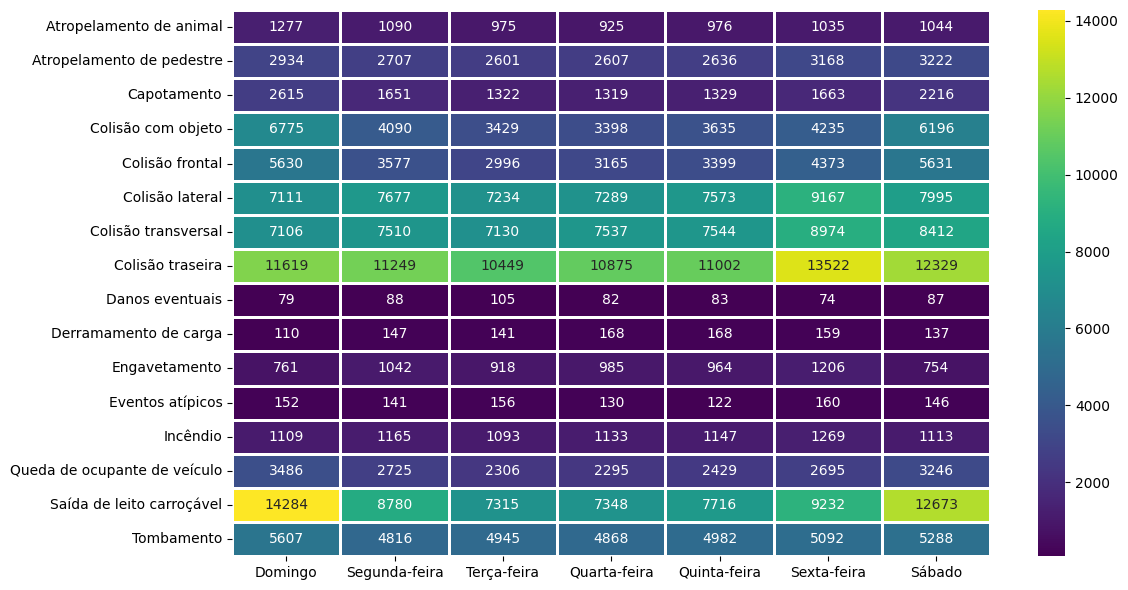

In [125]:
df = df_accidents.copy()
# df = df[df["tipo_acidente"].isin([
#     "Colisão traseira",
#     "Saída de leito carroçável",
#     "Colisão transversal",
#     "Colisão lateral",
#     "Tombamento"
# ])]
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'dia_semana']).size().unstack().fillna(0)
df = df[get_weekdays()]

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
plt.xlabel("")
plt.ylabel("")
# plt.title("Distribuição de acidentes por tipo de acidente e dia da semana")
plt.tight_layout()
plt.show()

#### tipo_acidente x horario

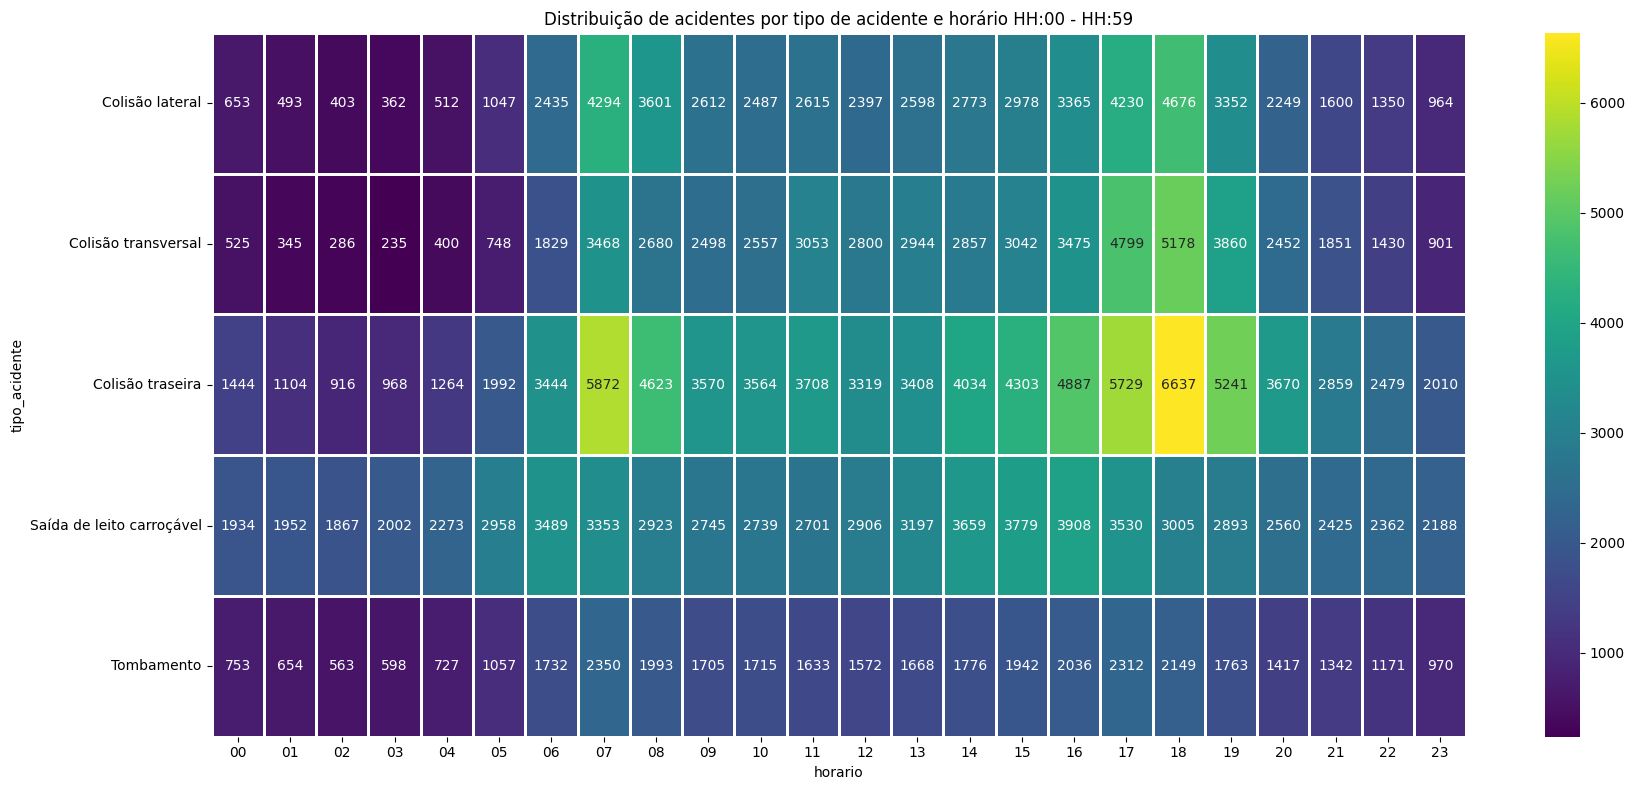

In [126]:
df = df_accidents.copy()
df = df[df["tipo_acidente"].isin([
    "Colisão traseira",
    "Saída de leito carroçável",
    "Colisão transversal",
    "Colisão lateral",
    "Tombamento"
])]
df.dropna(inplace=True)
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['tipo_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(18, 8))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### tipo_acidente x fase_dia

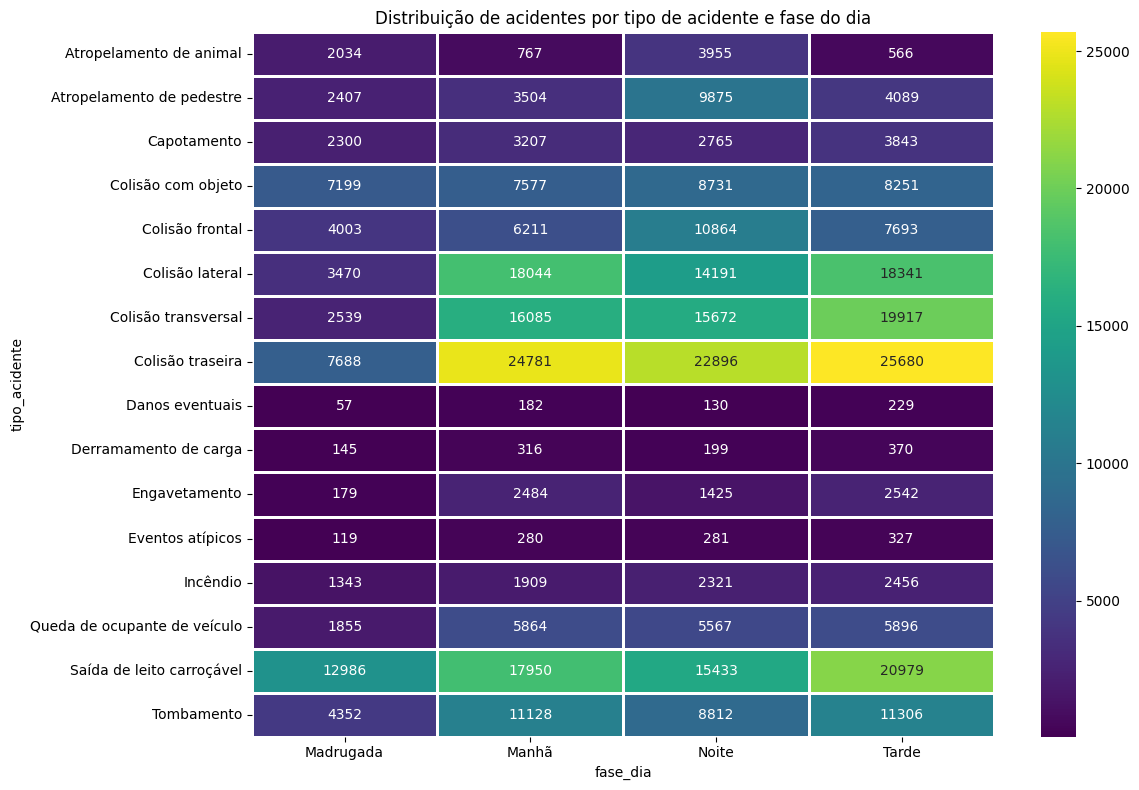

In [127]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e fase do dia")
plt.tight_layout()
plt.show()

#### tipo_acidente x condicao_metereologica

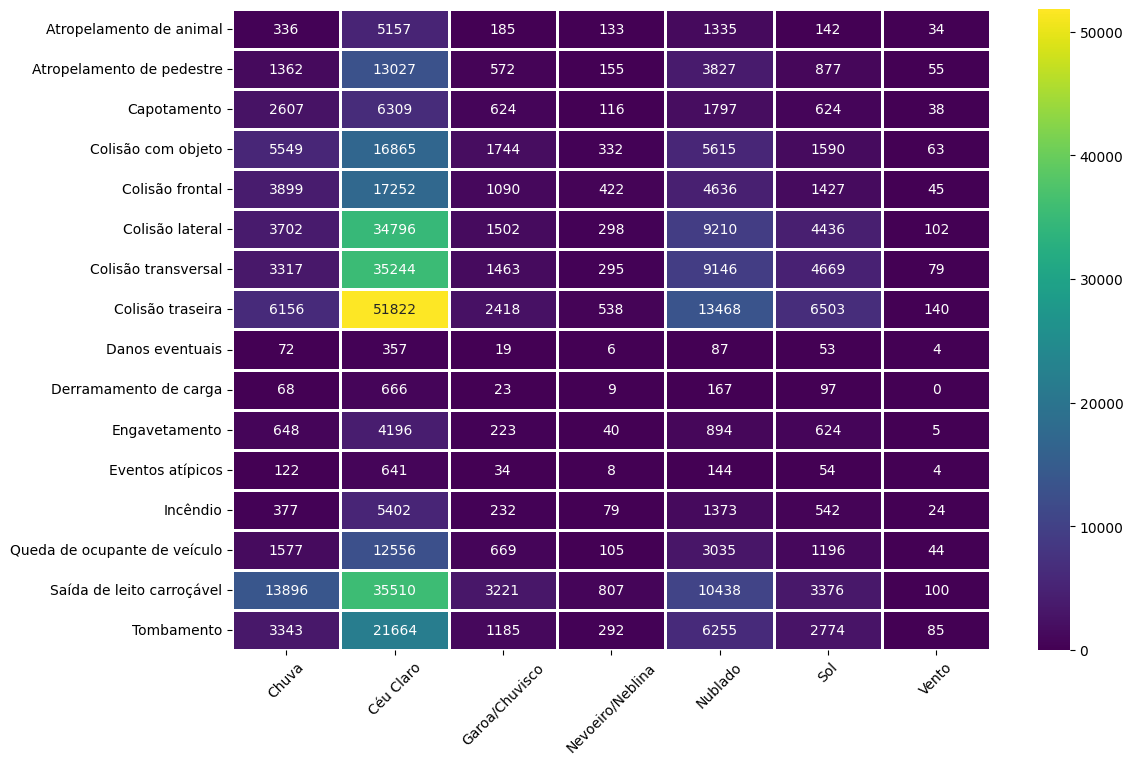

In [128]:
df = df_accidents.copy()
# df = df[df["tipo_acidente"].isin([
#     "Colisão traseira",
#     "Saída de leito carroçável",
#     "Colisão transversal",
#     "Colisão lateral",
#     "Tombamento"
# ])]
df.dropna(inplace=True)
# Sem dados expressivos para análise
# df = df[~df["condicao_metereologica"].isin(["Neve", "Granizo", "Vento"])]
df = df.groupby(
    [
        'tipo_acidente',
        'condicao_metereologica'
    ]
).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"
df.to_csv("condicao.csv")

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Distribuição de acidentes por tipo de acidente e condição meteorológica")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### tipo_acidente x uf

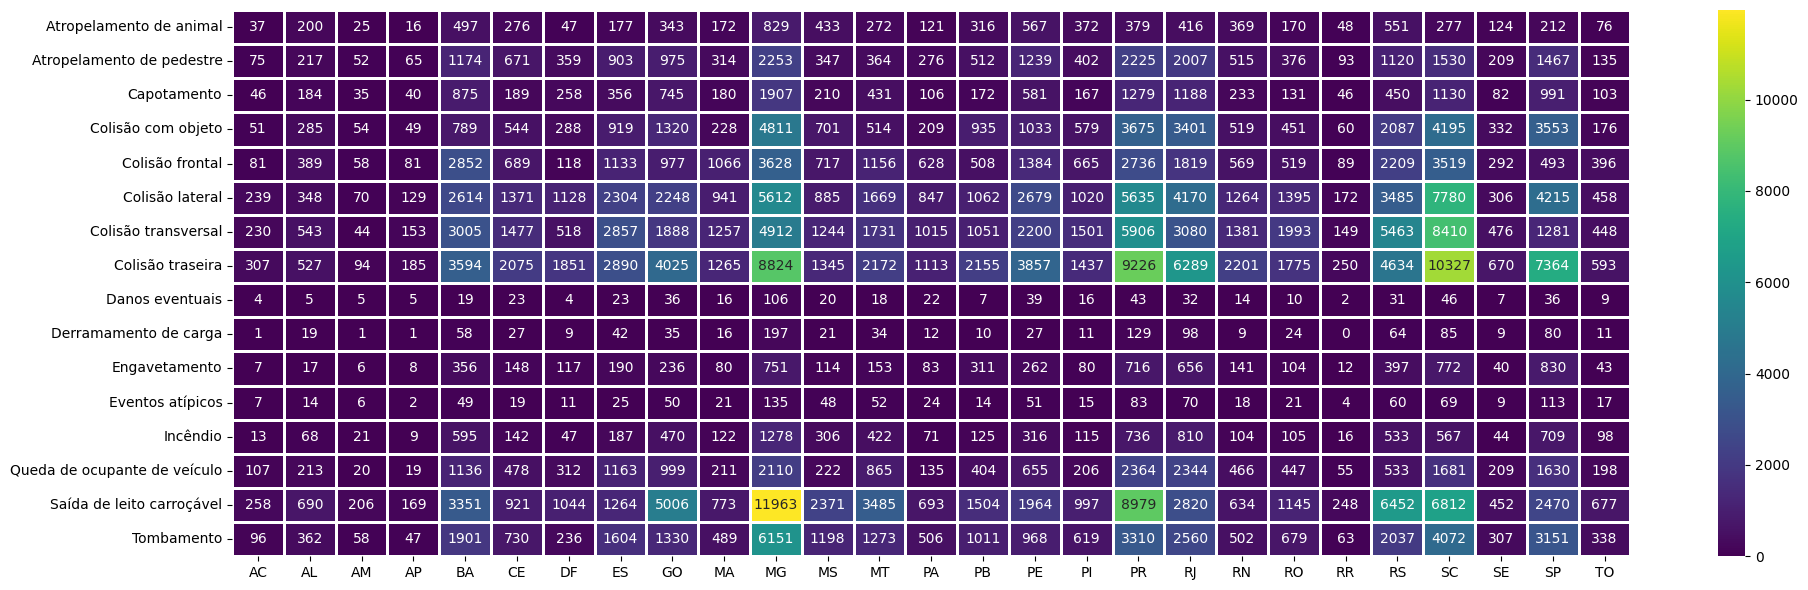

In [129]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'uf']).size().unstack().fillna(0)
df.to_csv("states.csv")

plt.figure(figsize=(20, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Frequência de acidentes por tipo de acidente e estado")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (com dados expressivos para análise)

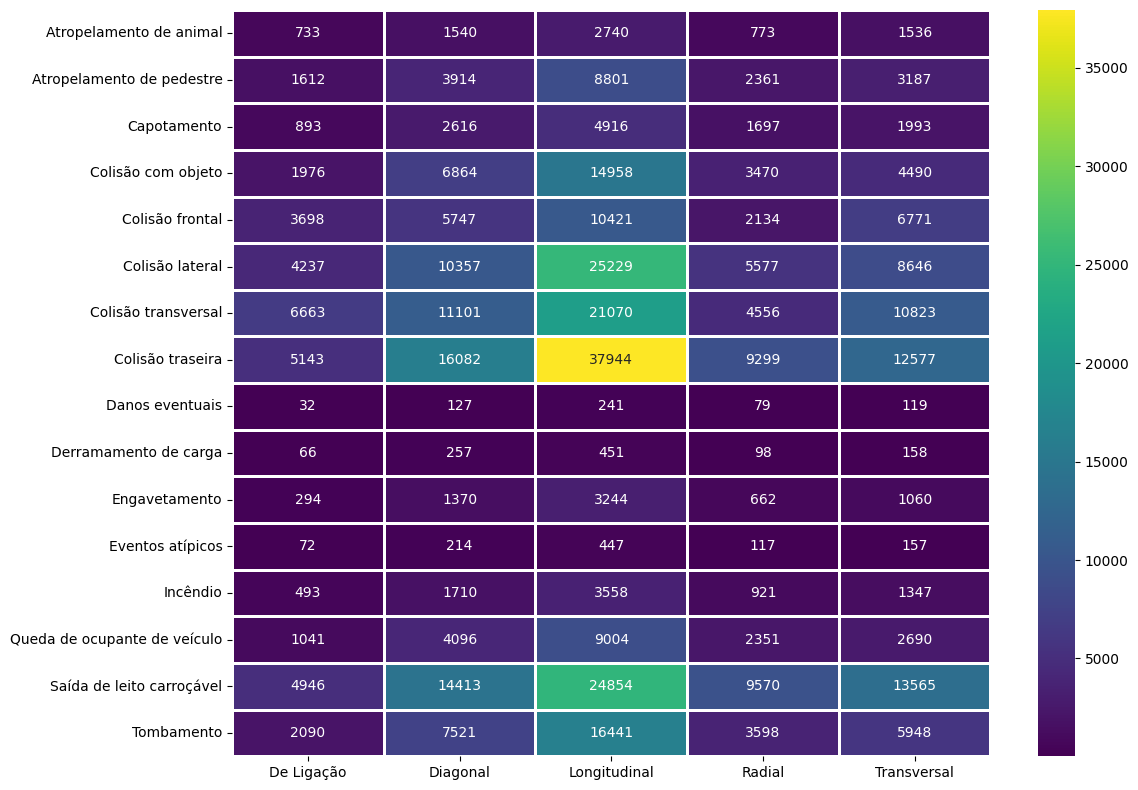

In [130]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'br_tipo']).size().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Frequência de acidentes por tipo de acidente e rodovias")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x uso_solo

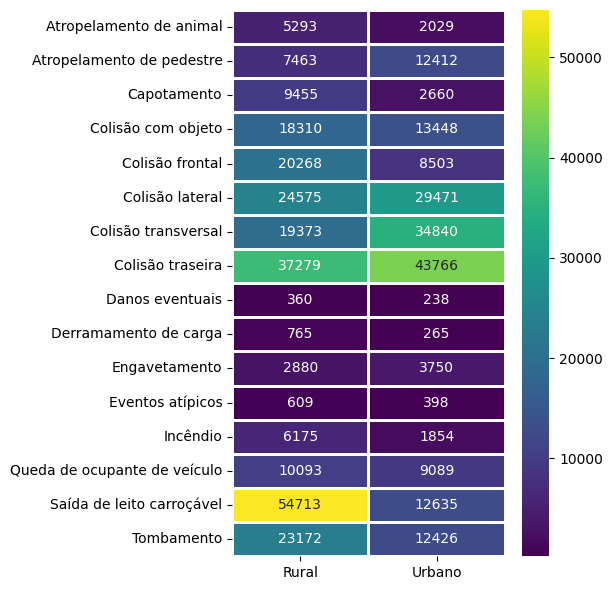

In [131]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(6, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Distribuição de acidentes por tipo de acidente e uso do solo")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x tipo_pista

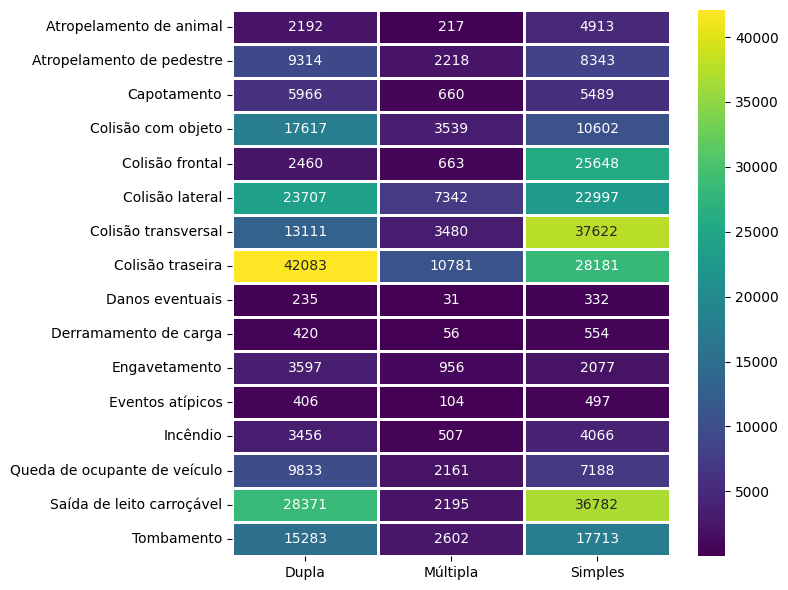

In [132]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Distribuição de acidentes por tipo de acidente e tipo de pista")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x sentido_via

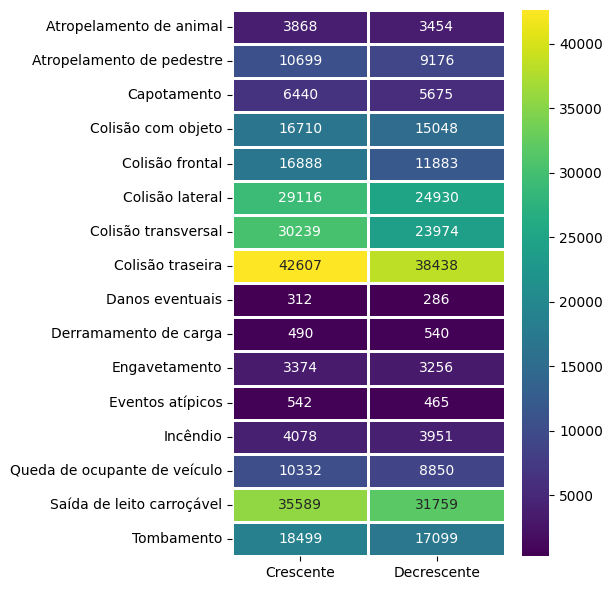

In [133]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(6, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Distribuição de acidentes por tipo de acidente e sentido da via")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x causa_acidente (10 principais)

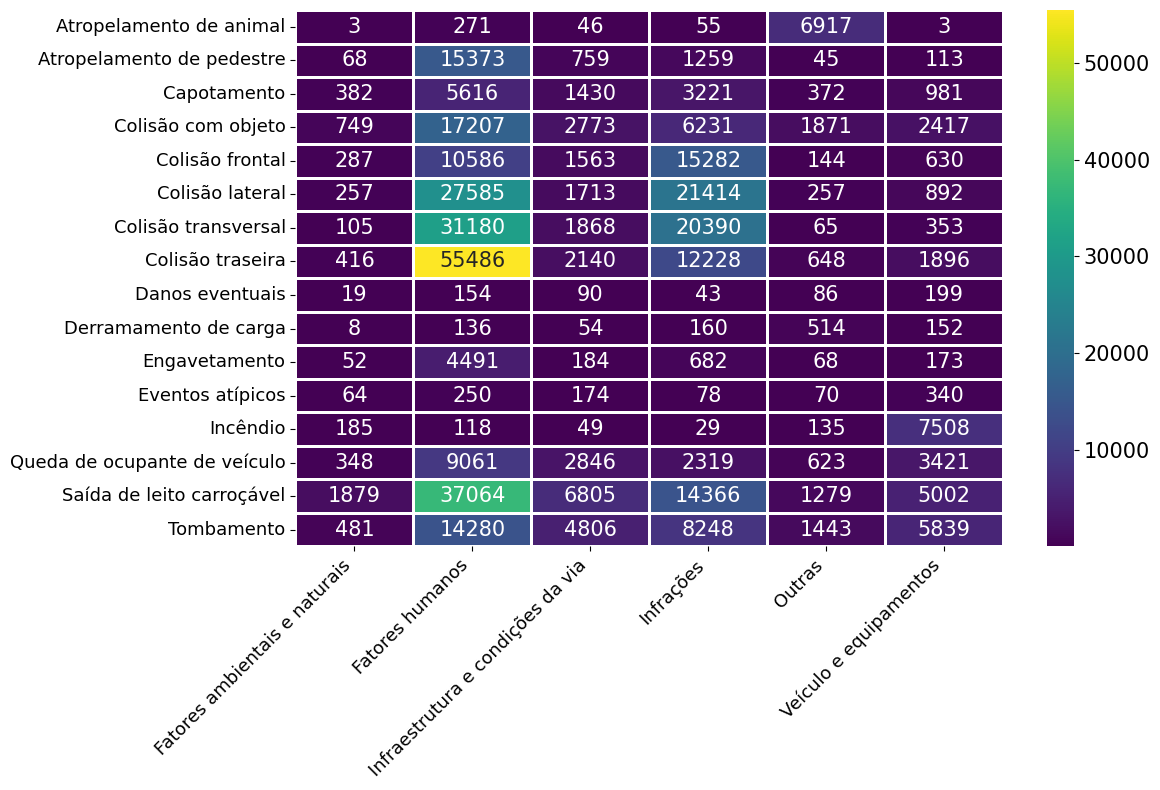

In [134]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[~df["causa_acidente_categoria"].isin(["Desconhecida"])]
df = df.groupby(['tipo_acidente', 'causa_acidente_categoria']).size().unstack().fillna(0)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1, annot_kws={"size": 15})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# plt.title(
#     "Distribuição de acidentes por tipo de acidente e causa de acidente")
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=13, ha="right", rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

#### tipo_acidente x classificacao_acidente

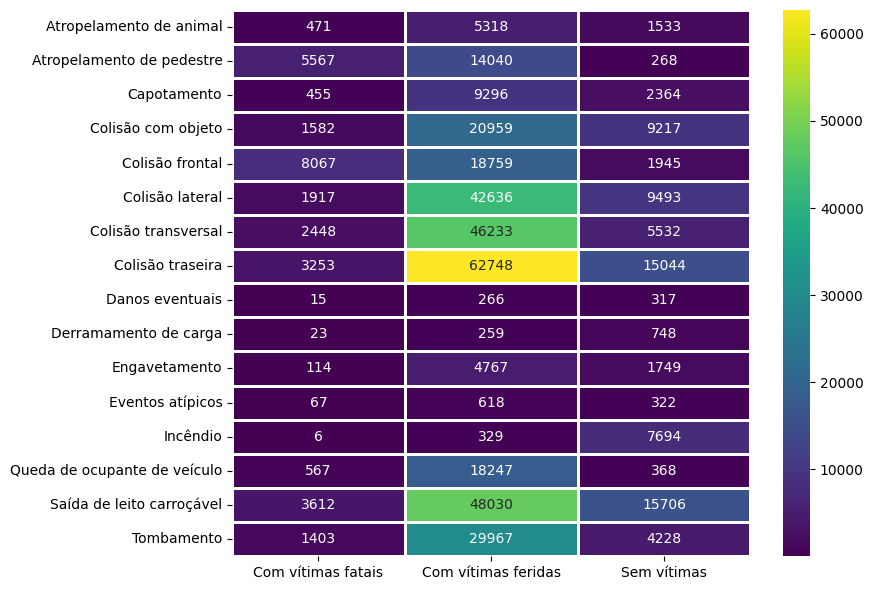

In [135]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(
    [
        'tipo_acidente',
        'classificacao_acidente'
    ]
).size().unstack().fillna(0)

plt.figure(figsize=(9, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title(
#     "Distribuição de acidentes por tipo de acidente e classificação do acidente")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x pessoas (top 4)

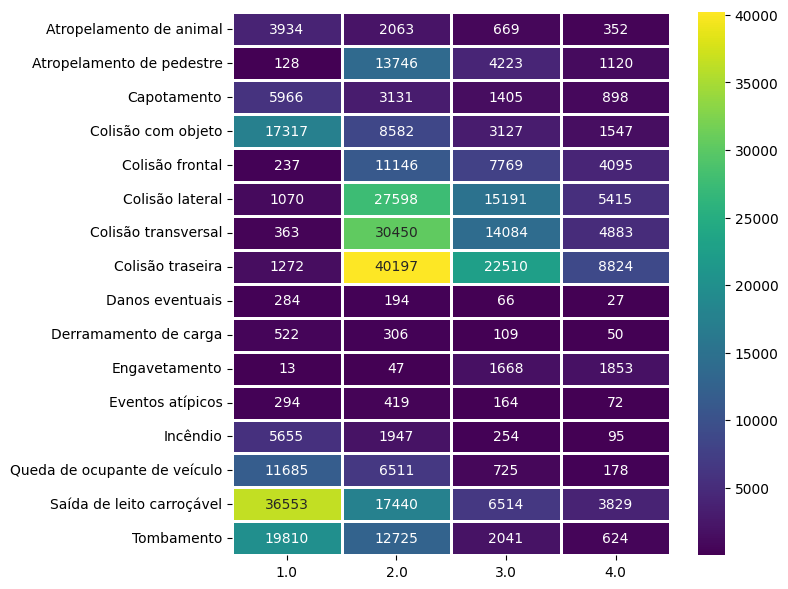

In [136]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[df["pessoas"].isin(
    df["pessoas"].value_counts().nlargest(4).index)]
df = df.groupby(['tipo_acidente', 'pessoas']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title(
#     "Distribuição de acidentes por tipo de acidente e pessoas envolvidas")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### tipo_acidente x veiculos (top 3)

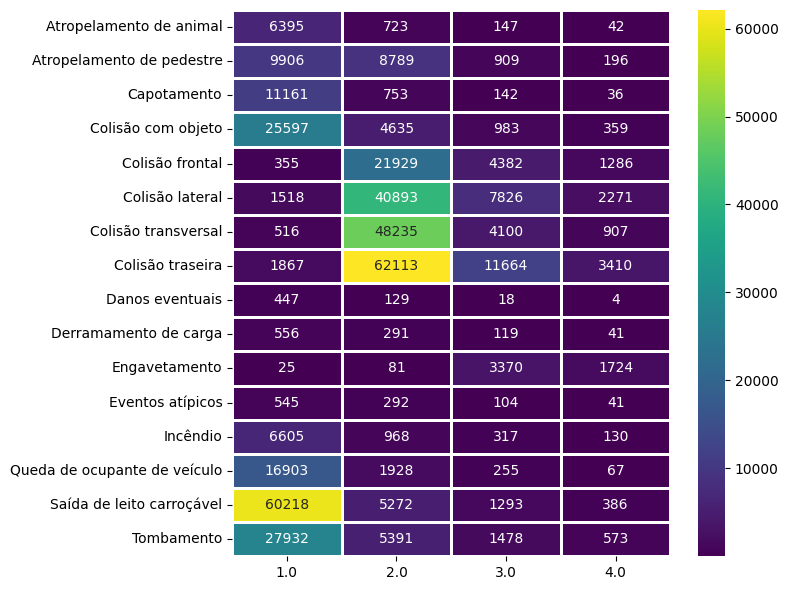

In [137]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[df["veiculos"].isin(
    df["veiculos"].value_counts().nlargest(4).index)]
df = df.groupby(['tipo_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f", lw=1)
# plt.title("Distribuição de acidentes por tipo de acidente e veículos envolvidos")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Análise multivariada

#### tipo_acidente x fase_dia x dia_semana x condicacao_metereologica

In [138]:
df = df_accidents.copy()
df["dia_semana"] = pd.Categorical(df["dia_semana"], categories=get_weekdays(), ordered=True)
df = df.dropna(subset=["dia_semana", "fase_dia", "condicao_metereologica"])

# Agrupa por todas as 3 dimensões e conta os tipos de acidentes
grouped = df.groupby([
    "dia_semana",
    "fase_dia",
    "condicao_metereologica",
    "tipo_acidente"
]).size().reset_index(name='contagem')

for (dia_semana, condicao_metereologica), sub_df in grouped.groupby([
    "fase_dia",
    "condicao_metereologica"
]):
    pivot = sub_df.pivot_table(
        index="tipo_acidente", columns="dia_semana", values="contagem", fill_value=0)

    if pivot.empty:
        continue

    draw_heatmap_in_subplots(
        pivot=pivot,
        title=f"{dia_semana} | {condicao_metereologica}"
    )

Output hidden; open in https://colab.research.google.com to view.

#### tipo_acidente x br x uso_solo x tipo_pista x sentido_via

In [139]:
df = df_accidents.copy()
# df = df[df["br"].isin(df["br"].value_counts().nlargest(10).index)]
df = df.dropna(subset=["br_tipo", "uso_solo", "tipo_pista", "sentido_via"])

# Agrupa por todas as 3 dimensões e conta os tipos de acidentes
grouped = df.groupby([
    "uso_solo",
    "tipo_pista",
    "sentido_via",
    "br_tipo",
    "tipo_acidente"
]).size().reset_index(name='contagem')

for (uso_solo, tipo_pista, sentido_via), sub_df in grouped.groupby([
    "uso_solo",
    "tipo_pista",
    "sentido_via"
]):
    pivot = sub_df.pivot_table(
        index="tipo_acidente", columns="br_tipo", values="contagem", fill_value=0)

    if pivot.empty:
        continue

    draw_heatmap_in_subplots(
        pivot=pivot,
        title=f"{uso_solo} | {tipo_pista} | {sentido_via}",
        column=20
    )

Output hidden; open in https://colab.research.google.com to view.

## Correlação

### Cramers V para identificar a correlação entre as categorias

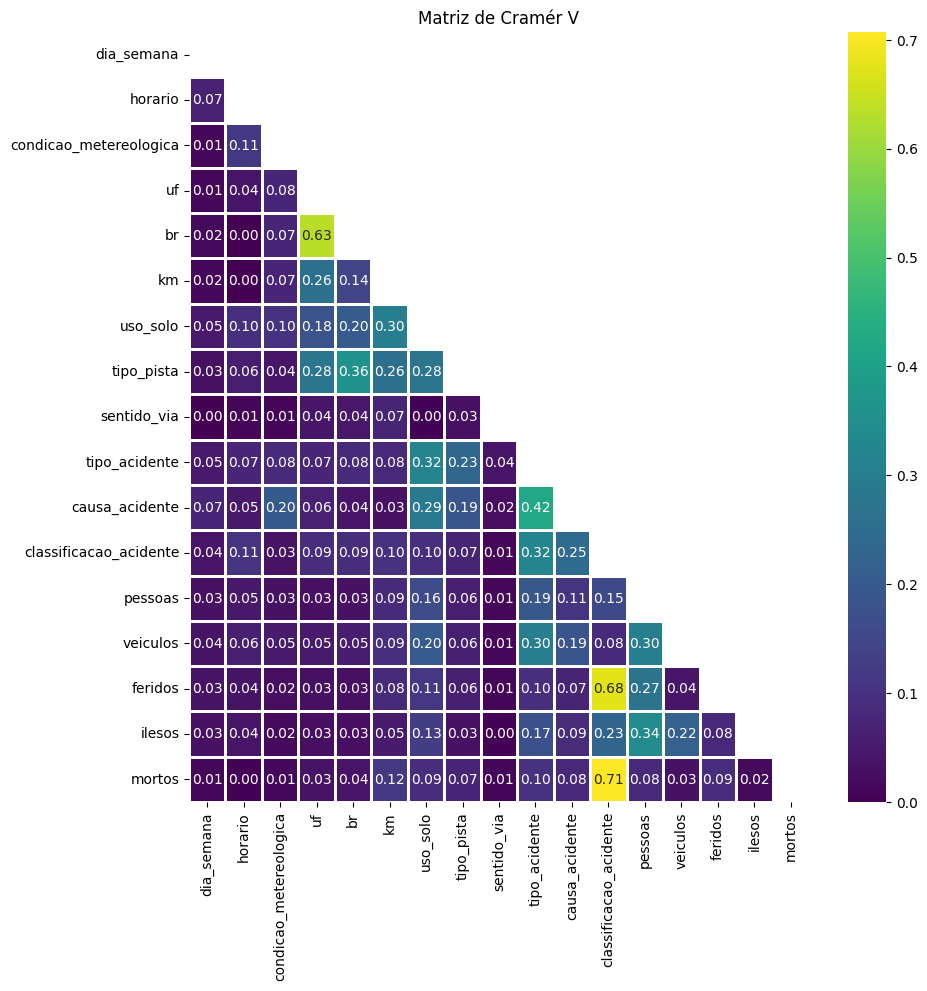

In [140]:
df_correlation = df_accidents.copy()
df_correlation.dropna(inplace=True)
df_correlation.drop(columns=[
    "mes_ano",
    "tipo_data",
    "br_tipo",
    "causa_acidente_categoria",
    "fase_dia"
], inplace=True)
df_correlation.set_index("id", inplace=True)


def apply_cramers_v(crosstab):
    chi2, _, _, _ = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    r, k = crosstab.shape
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))


cols = df_correlation.columns
n = len(cols)

df_results = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in range(n):
    for j in range(i, n):
        col_x = cols[i]
        col_y = cols[j]
        result = apply_cramers_v(pd.crosstab(
            df_correlation[col_x], df_correlation[col_y]))
        df_results.loc[col_x, col_y] = result
        df_results.loc[col_y, col_x] = result

plt.figure(figsize=(10, 10))
sns.heatmap(
    df_results,
    mask=np.triu(np.ones_like(df_results, dtype=bool)),
    fmt=".2f",
    annot=True,
    cmap="viridis",
    lw=1
)
plt.title("Matriz de Cramér V")
plt.show()

## Análise dos componentes principais

#### Transformando cada categoria em uma coluna binária com One Hot

In [141]:
df_pca = df_accidents.copy()
df_pca.dropna(inplace=True)
df_pca.set_index("id", inplace=True)
df_pca.drop(
    columns=[
        "mes_ano",
        "horario",
        "km",
        "br",
        "br_tipo",
        "pessoas",
        "veiculos",
        "tipo_data",
        "causa_acidente_categoria",
        "mortos",
        "ilesos",
        "feridos"
    ],
    inplace=True)
df_pca = df_pca.reset_index()


encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_sparse = encoder.fit_transform(df_pca.select_dtypes(include='object'))
X_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4285670 stored elements and shape (428567, 154)>

#### Padronizando as features

In [142]:
svd = TruncatedSVD(n_components=45)
X_reduzido = svd.fit_transform(X_sparse)
X_reduzido

array([[ 1.34483196,  0.68583585,  0.67144541, ..., -0.0371456 ,
         0.03784223, -0.1694814 ],
       [ 1.76425577,  0.39242094,  0.63404778, ..., -0.0793169 ,
         0.066832  ,  0.00203851],
       [ 1.53820776, -0.8980516 , -0.55355091, ...,  0.07043751,
         0.0890805 ,  0.0898598 ],
       ...,
       [ 1.73250758, -0.04389327,  0.93839231, ..., -0.06789837,
        -0.01429271, -0.04403098],
       [ 1.56987127, -0.82903779,  0.82599795, ..., -0.1101517 ,
         0.01512774, -0.16672299],
       [ 1.56844736, -0.82856477,  0.82810701, ..., -0.43041654,
         0.18553745, -0.37795273]])

#### Criando Data Frame com componentes principais

In [143]:
principalDf = pd.DataFrame(
    data=X_reduzido,
    columns=[f'PC{n}' for n in range(1, 46)]
)
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428567 entries, 0 to 428566
Data columns (total 45 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC1     428567 non-null  float64
 1   PC2     428567 non-null  float64
 2   PC3     428567 non-null  float64
 3   PC4     428567 non-null  float64
 4   PC5     428567 non-null  float64
 5   PC6     428567 non-null  float64
 6   PC7     428567 non-null  float64
 7   PC8     428567 non-null  float64
 8   PC9     428567 non-null  float64
 9   PC10    428567 non-null  float64
 10  PC11    428567 non-null  float64
 11  PC12    428567 non-null  float64
 12  PC13    428567 non-null  float64
 13  PC14    428567 non-null  float64
 14  PC15    428567 non-null  float64
 15  PC16    428567 non-null  float64
 16  PC17    428567 non-null  float64
 17  PC18    428567 non-null  float64
 18  PC19    428567 non-null  float64
 19  PC20    428567 non-null  float64
 20  PC21    428567 non-null  float64
 21  PC22    42

#### Proporção da variância total dos dados

In [144]:
svd.explained_variance_ratio_

array([0.0085682 , 0.08672928, 0.0724014 , 0.06029158, 0.04789372,
       0.04308676, 0.04250844, 0.03827774, 0.02689868, 0.02467138,
       0.02386564, 0.02210954, 0.02139988, 0.02052433, 0.02017193,
       0.01958876, 0.01916556, 0.01858571, 0.0182296 , 0.01814351,
       0.01717256, 0.01687686, 0.01500888, 0.0146734 , 0.01386536,
       0.01357949, 0.01125689, 0.01101485, 0.01063919, 0.01035598,
       0.01023086, 0.00996176, 0.00953678, 0.00891509, 0.00809892,
       0.0078263 , 0.00765165, 0.00718926, 0.00700489, 0.00643231,
       0.00635396, 0.00582012, 0.00561503, 0.00523944, 0.00505291])

#### Soma das proporções da variância total dos dados

In [145]:
sum(svd.explained_variance_ratio_[0:46])*100

np.float64(89.84843763293992)

#### Removendo colunas que não se fazem necessárias após análise

In [146]:
# df_accidents.set_index("id", inplace=True)
# df_accidents.drop(columns=["horario", "km", "tipo_data", "causa_acidente"], inplace=True)
# df_accidents.info()

## Remoção de outliers após análises

#### Condições meteorológicas que não possuem dados significativos

In [147]:
# df = df_accidents.copy()
# df.dropna(inplace=True)
# df = df[~df["condicao_metereologica"].isin(
#     [
#         "Nevoeiro/Neblina",
#         "Vento"
#     ]
# )]
# df_accidents = df
# df_accidents.shape

#### Tipos de acidente que não tem dados significativos

In [148]:
# df = df_accidents.copy()
# df.dropna(inplace=True)
# df = df[~df["tipo_acidente"].isin(
#     [
#         "Eventos atípicos",
#         "Danos eventuais",
#         "Derramamento de carga"
#     ]
# )]
# df_accidents = df
# df_accidents.shape

#### Salvando os dados em um novo CSV após análise dados

In [149]:
df_accidents.to_csv(
    path_or_buf="/content/datatran2018_2024_v3.csv",
    index=False
)

In [150]:
df_accidents["tipo_acidente"].value_counts()

tipo_acidente
Colisão traseira                81045
Saída de leito carroçável       67348
Colisão transversal             54213
Colisão lateral                 54046
Tombamento                      35598
Colisão com objeto              31758
Colisão frontal                 28771
Atropelamento de pedestre       19875
Queda de ocupante de veículo    19182
Capotamento                     12115
Incêndio                         8029
Atropelamento de animal          7322
Engavetamento                    6630
Derramamento de carga            1030
Eventos atípicos                 1007
Danos eventuais                   598
Name: count, dtype: int64

In [151]:
df_accidents["condicao_metereologica"].value_counts()

condicao_metereologica
Céu Claro           261464
Nublado              71427
Chuva                47031
Sol                  28984
Garoa/Chuvisco       15204
Nevoeiro/Neblina      3635
Vento                  822
Name: count, dtype: int64